In [1]:
%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import sklearn
import datetime
import array 
import math

import shapefile as sf
from matplotlib.patches import Polygon
import mpld3

from pyproj import Proj
from censusgeocode import CensusGeocode
from matplotlib.collections import PatchCollection

In [2]:
font={'family': 'serif', 
       'weight': 'normal', 
        'size' : 13, 
        'style' : 'oblique' }
plt.rc('font', **font)
plt.rc('xtick', color='k', labelsize='medium', direction='in')
plt.rc('xtick.major', size=6, pad=4)
plt.rc('xtick.minor', size=3, pad=4)
plt.rc('ytick.major', size=6, pad=4)
plt.rc('ytick.minor', size=3, pad=4)

#### Read in the 311 requests, organised by block group.

In [3]:
total_reports_demo = pd.read_csv('output_files/total_reports_demo_0917.csv')

#### Read in the census information, organised by block group

In [4]:
census_trimmed = pd.read_csv('output_files/census_trimmed_0917.csv')

#### Code violation information, organised by block group

In [5]:
cv_records = pd.read_csv('output_files/code_violations_6mo_bg.csv')

#### Police calls that result in arrest information, organised by block group

In [6]:
# FILE NOT COMPLETED YET. 
#arrest_records = pd.read_csv('output_files/police_arrests_bg.csv')

#### Combine the information together

In [7]:
temp1 = pd.merge(total_reports_demo, census_trimmed, on=['tract', 'blockgroup'], how='left')
census_combo = pd.merge(temp1, cv_records, on=['tract', 'blockgroup'], how='left')

Shapefile reader for San Diego city proper

In [8]:
mc_reader = sf.Reader('shapefiles/Municipal_Boundaries/MUNICIPAL_BOUNDARIES.shp')
mc_records = pd.DataFrame(mc_reader.records())
mc_shapes = mc_reader.shapes()

mc_records_index = np.where(mc_records[1]=='SD')

Shapefile reader for all of the block groups in SD county

In [9]:
# Blockgroup shape file
reader = sf.Reader('shapefiles/tl_2016_06_bg/tl_2016_06_bg.shp')
bg_info = pd.DataFrame(reader.records())
shapes = reader.shapes()

# the San Diego county shapefile records
sdcounty = bg_info.loc[np.where((bg_info[1]=='073') & (bg_info[3]!='0'))[0]]
sdcounty_index = np.where((bg_info[1]=='073') & (bg_info[3]!='0'))[0]

In [10]:
sdcounty.rename(columns={2: 'tract', 3: 'blockgroup', 10: 'cent_lat', 11: 'cent_lon'}, 
                inplace=True)

In [11]:
sdcounty['tract'] = sdcounty['tract'].astype(float)
sdcounty['blockgroup'] = sdcounty['blockgroup'].astype(float)
sdcounty['cent_lat'] = sdcounty['cent_lat'].astype(float)
sdcounty['cent_lon'] = sdcounty['cent_lon'].astype(float)

In [12]:
# Read in Jeff's list of census tracts in SD city proper 
sd_city_proper = pd.read_csv('SD_city_census_tracts.txt')

sd_city_proper['tract'] = sd_city_proper['tract'].astype(float)

In [151]:
# Read in the edited list i made of block groups that are in municipal-range census tracts, 
# but not within the city itself
sd_bg_edited = pd.read_csv('tract_blockgroups_to_ignore.csv')
sd_bg_edited['blockgroup'] = sd_bg_edited['blockgroup'].astype(float)
sd_bg_edited['tract'] = sd_bg_edited['tract'].astype(float)

In [152]:
for i in range(0,10): 
    temp_tract = census_combo.loc[i, 'tract']
    temp_bg = census_combo.loc[i, 'blockgroup']
    if (len(np.where((sd_bg_edited['tract']==temp_tract) 
                         & (sd_bg_edited['blockgroup']==temp_bg))[0])>0):
        census_combo.loc[i, 'tract_in_city'] = 0.0

32


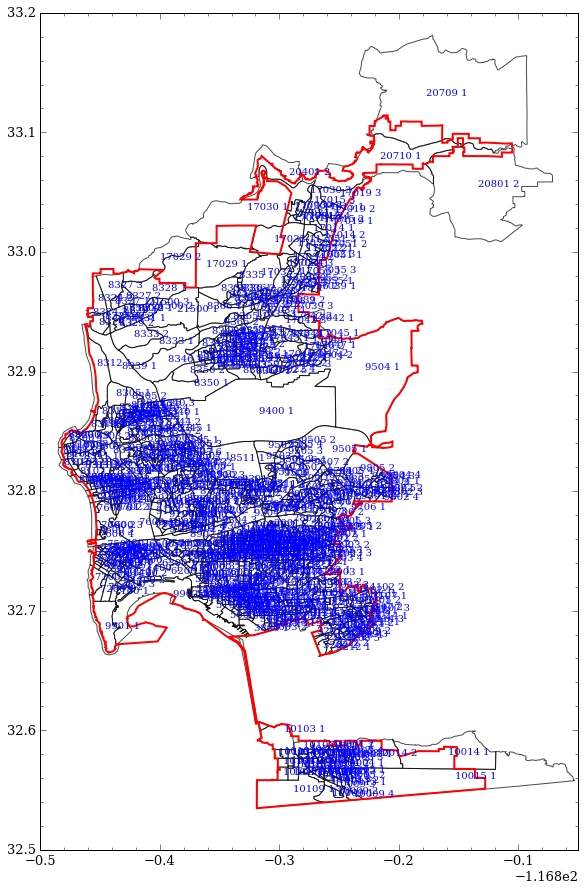

In [149]:
p1 = Proj("+init=EPSG:2230", preserve_units=True)

fig,ax = plt.subplots(1,1, figsize=(15,15))

patches1 = []
for i in range(32,33): 
    print i
    temp = pd.DataFrame(mc_shapes[i].points)
    lon, lat = p1(np.array(temp.loc[0:33632, 0]), np.array(temp.loc[0:33632, 1]), inverse=True)
    poly = plt.Polygon(np.transpose([lon,lat]), fc='none', ec='r', alpha=1.0, lw=2.0, zorder=3)
    patches1.append(poly)
    plt.gca().add_patch(poly)


patches = []
for i in range(0,len(sdcounty_index)): 
    if (len(np.where(sd_city_proper['tract'] == sdcounty.loc[sdcounty_index[i], 
                                                             'tract'])[0])>0): 
        temp_tract = sdcounty.loc[sdcounty_index[i],'tract']
        temp_bg = sdcounty.loc[sdcounty_index[i], 'blockgroup']
        
        if (len(np.where((sd_bg_edited['tract']==temp_tract) 
                         & (sd_bg_edited['blockgroup']==temp_bg))[0])==0): 
            barf = pd.DataFrame(shapes[sdcounty_index[i]].points)
            poly = plt.Polygon(barf[[0,1]], fc='none', ec='k', alpha=0.7)
            patches.append(poly)
            namer = (sdcounty.loc[sdcounty_index[i], 'tract'].astype(int).astype(str) + ' ' 
                     + sdcounty.loc[sdcounty_index[i], 'blockgroup'].astype(int).astype(str))
            plt.text(sdcounty.loc[sdcounty_index[i], 'cent_lon'], 
                     sdcounty.loc[sdcounty_index[i], 'cent_lat'], namer, fontsize=10, color='b')
            plt.gca().add_patch(poly)

plt.axis('scaled')
plt.minorticks_on()


In [154]:
census_combo.columns.values

array(['Unnamed: 0', 'tract', 'blockgroup', 'count', 'graffiti_count',
       'dump_count', 'lighting_count', 'gsl_meandist', 'gsl_stddist',
       'gsl_mediandist', 'dsl_meandist', 'dsl_stddist', 'dsl_mediandist',
       'sl_count', 'landarea', 'cent_lat', 'cent_lon', 'sl_density',
       'total_pop', 'rep_per_cap', 'graffiti_per', 'dump_per',
       'lighting_per', 'tract_in_city', 'male_5_17', 'male_18_29',
       'male_30_60', 'male_61plus', 'female_5_17', 'female_18_29',
       'female_30_60', 'female_61plus', 'rent_0_500', 'rent_501_1000',
       'rent_1000plus', 'income_0_25', 'income_25_50', 'income_50_100',
       'income_100_150', 'income_150plus', 'white_per', 'baa_per',
       'aian_per', 'asian_per', 'pi_per', 'other_per', 'tp_per',
       'latin_per', 'publica_per', 'ownerocc_per', 'median_house_income',
       'median_structure_year', 'median_home_value', 'median_age',
       'median_age_white', 'median_age_latin', 'median_contract_rent',
       'limited_english_househol

32


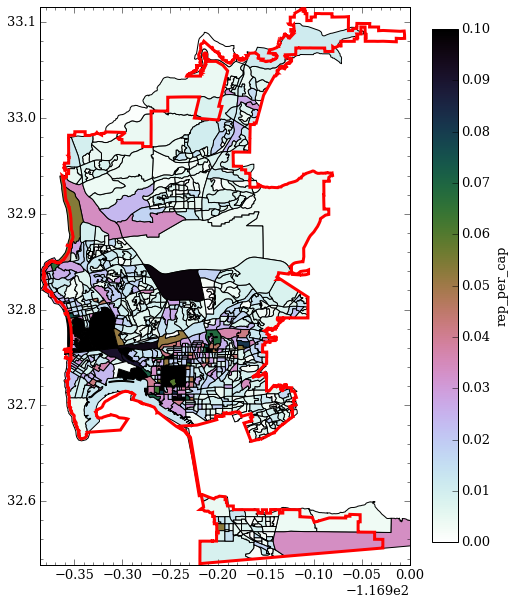

In [159]:
column_choice = 'rep_per_cap'
#column_choice = 'Estimate; Total'

p1 = Proj("+init=EPSG:2230", preserve_units=True)

fig,ax = plt.subplots(1,1, figsize=(10,10))
patches = []
col_values = []
for i in range(0,len(sdcounty_index)): 
    if (len(np.where(sd_city_proper['tract'] == sdcounty.loc[sdcounty_index[i], 'tract'])[0])>0): 
        temp_tract = sdcounty.loc[sdcounty_index[i],'tract']
        temp_bg = sdcounty.loc[sdcounty_index[i], 'blockgroup']
        if (len(np.where((sd_bg_edited['tract']==temp_tract) 
                         & (sd_bg_edited['blockgroup']==temp_bg))[0])==0): 
            col_values.append(census_combo.loc[i, column_choice])
            barf = pd.DataFrame(shapes[sdcounty_index[i]].points)
            poly = plt.Polygon(barf[[0,1]], fc='none', ec='k', alpha=0.7)
            patches.append(poly)
    #plt.gca().add_patch(poly)

colors = col_values

p = PatchCollection(patches, cmap='cubehelix_r', alpha=1.0)
p.set_array(np.array(colors))
p.set_clim([min(colors),0.30])
p.set_clim([min(colors),0.1])

ax.add_collection(p)

patches1 = []
for i in range(32,33): 
    print i
    temp = pd.DataFrame(mc_shapes[i].points)
    lon, lat = p1(np.array(temp.loc[0:33632, 0]), np.array(temp.loc[0:33632, 1]), inverse=True)
    poly = plt.Polygon(np.transpose([lon,lat]), fc='none', ec='r', alpha=1.0, lw=3.0, zorder=3)
    patches1.append(poly)
    plt.gca().add_patch(poly)


plt.axis('scaled')
plt.minorticks_on()

plt.colorbar(p, fraction=0.046, pad=0.04, shrink=1.0, label=column_choice)

plt.ylim(32.533541,33.116178)
plt.xlim(-117.285629,-116.9)

plt.show()
#mpld3.display()

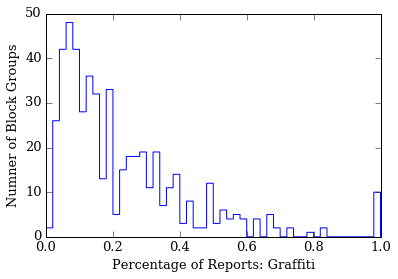

In [13]:
a = plt.hist(census_combo['graffiti_per'], bins=50, range=[0.001,1], histtype='step')
plt.xlabel('Percentage of Reports: Graffiti')
plt.ylabel('Number of Block Groups')

In [160]:
census_combo[['asian_per', 'baa_per', 'white_per', 'latin_per']].describe()

,asian_per,baa_per,white_per,latin_per
count,1794.000000,1794.000000,1794.000000,1794.000000
mean,0.097764,0.044921,0.502999,0.314146
std,0.126991,0.066327,0.270445,0.246316
min,0.000000,0.000000,0.000000,0.000000
25%,0.018100,0.000000,0.278944,0.117679
50%,0.051675,0.018786,0.545962,0.236589
75%,0.124013,0.060400,0.729667,0.470509
max,0.897119,0.498345,1.000000,1.000000


In [200]:
barf = pd.read_csv('output_files/requests_processed_0917.csv')

/Users/kschles/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (17,19,43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [204]:
mobile = barf.loc[np.where(barf['Case Origin']=='Mobile')[0], ['tract','blockgroup',
                                                               'Case Origin']]
web = barf.loc[np.where(barf['Case Origin']=='Web')[0], ['tract','blockgroup',
                                                               'Case Origin']]
phone = barf.loc[np.where(barf['Case Origin']=='Phone')[0], ['tract','blockgroup',
                                                               'Case Origin']]

In [211]:
mobile_counts = mobile.groupby(['tract', 'blockgroup'], as_index=False).agg('count')
mobile_counts.rename(columns={'Case Origin': 'mobile_counts'}, inplace=True)

web_counts = web.groupby(['tract', 'blockgroup'], as_index=False).agg('count')
web_counts.rename(columns={'Case Origin': 'web_counts'}, inplace=True)

phone_counts = phone.groupby(['tract', 'blockgroup'], as_index=False).agg('count')
phone_counts.rename(columns={'Case Origin': 'phone_counts'}, inplace=True)

In [221]:
temp1 = pd.merge(census_combo, mobile_counts, on=['tract', 'blockgroup'], how='left')
temp2 = pd.merge(temp1, web_counts, on=['tract', 'blockgroup'], how='left')
census_big = pd.merge(temp2, phone_counts, on=['tract', 'blockgroup'], how='left')

In [219]:
census_big[['mobile_counts', 'web_counts', 'phone_counts']] = census_big[['mobile_counts', 'web_counts', 'phone_counts']].div(census_big['count'], axis=0)

You get fewer reports per capita from areas where more of the households have limited english.

(0, 0.1)

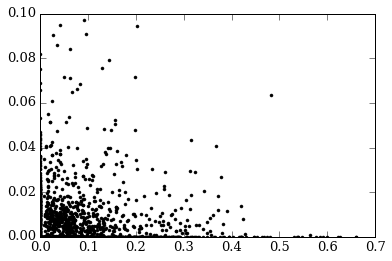

In [233]:
plt.plot(census_big['limited_english_households_per'],census_big['rep_per_cap'], 'k.')
#plt.ylim(0,30)
plt.ylim(0,0.10)


In [166]:
census_combo.columns.values

array(['Unnamed: 0', 'tract', 'blockgroup', 'count', 'graffiti_count',
       'dump_count', 'lighting_count', 'gsl_meandist', 'gsl_stddist',
       'gsl_mediandist', 'dsl_meandist', 'dsl_stddist', 'dsl_mediandist',
       'sl_count', 'landarea', 'cent_lat', 'cent_lon', 'sl_density',
       'total_pop', 'rep_per_cap', 'graffiti_per', 'dump_per',
       'lighting_per', 'tract_in_city', 'male_5_17', 'male_18_29',
       'male_30_60', 'male_61plus', 'female_5_17', 'female_18_29',
       'female_30_60', 'female_61plus', 'rent_0_500', 'rent_501_1000',
       'rent_1000plus', 'income_0_25', 'income_25_50', 'income_50_100',
       'income_100_150', 'income_150plus', 'white_per', 'baa_per',
       'aian_per', 'asian_per', 'pi_per', 'other_per', 'tp_per',
       'latin_per', 'publica_per', 'ownerocc_per', 'median_house_income',
       'median_structure_year', 'median_home_value', 'median_age',
       'median_age_white', 'median_age_latin', 'median_contract_rent',
       'limited_english_househol

Want to see if there is variation in the reporting frequency at a given income level with respect to percent of households with limited english. 

(10, 60000)

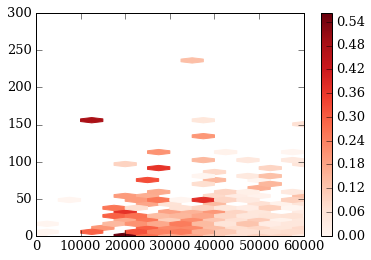

In [199]:
plt.hexbin(census_combo.loc[np.where(census_combo['tract_in_city']==1.0)[0],
                             'median_house_income'].astype(int), 
            census_combo.loc[np.where(census_combo['tract_in_city']==1.0)[0],'count'], 
            C=census_combo.loc[np.where(census_combo['tract_in_city']==1.0)[0],
                               'limited_english_households_per'], gridsize=50, cmap='Reds')
          #extent=[10,50000,0,100])
plt.colorbar()
plt.xlim(10,60000)
#plt.ylim(-0.01,0.15)

barf


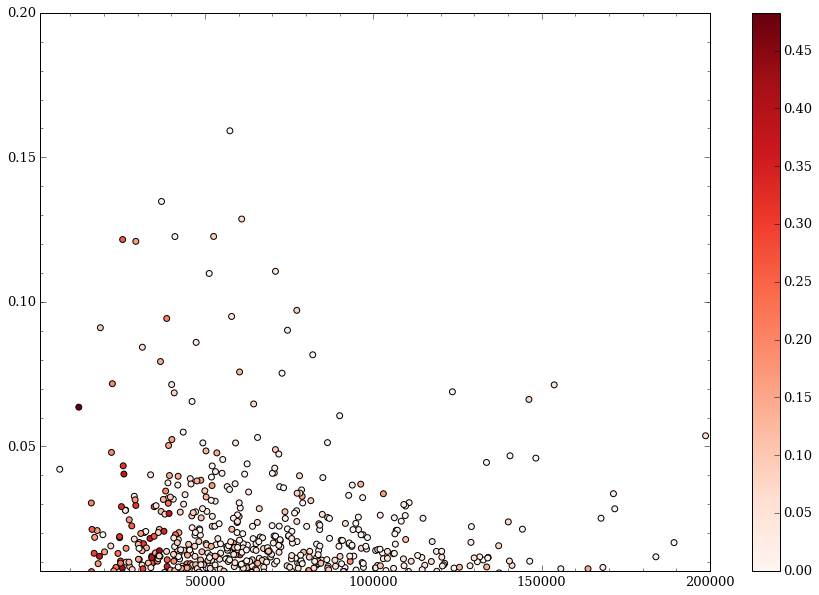

In [170]:
fig, test = plt.subplots(1,1, figsize=(15,10), sharey=True)
#fig.subplots_adjust(hspace=.5)
fig.subplots_adjust(wspace=.00)

cs = test.scatter(census_combo.loc[np.where(census_combo['count']>=10)[0], 'median_house_income'].astype(int),
            census_combo.loc[np.where(census_combo['count']>=10)[0], 'rep_per_cap'],
            c=census_combo.loc[np.where(census_combo['count']>=10)[0], 'limited_english_households_per'], 
            cmap='Reds', s=35, vmin=0)
test.set_xlim(1000,200000)
test.set_ylim(0.007,0.2)
test.minorticks_on()
cb=plt.colorbar(cs, label='', ax=test)
"""
cs2 = test[1].scatter(census_combo.loc[np.where(census_combo['count']>=10)[0], 'median_house_income'].astype(int),
            census_combo.loc[np.where(census_combo['count']>=10)[0], 'rep_per_cap'],
            c=census_combo.loc[np.where(census_combo['count']>=10)[0], 'latin_per'], 
            cmap='Blues', s=35, vmin=0, vmax=1.0)
test[1].set_xlim(1000,200000)
test[1].set_ylim(0,0.20)
test[1].minorticks_on()

#cb=plt.colorbar(cs2, label='Percent Latinx/Hispanic', ax=test[1])

cs2 = test[2].scatter(census_combo.loc[np.where(census_combo['count']>=10)[0], 'median_house_income'].astype(int),
            census_combo.loc[np.where(census_combo['count']>=10)[0], 'rep_per_cap'],
            c=census_combo.loc[np.where(census_combo['count']>=10)[0], 'asian_per'], 
            cmap='Blues', s=35, vmin=0, vmax=1.0)
test[2].set_xlim(1000,200000)
test[2].set_ylim(0,0.20)
test[2].minorticks_on()

#cb = plt.colorbar(cs2, label='Percent Asian', ax=test[2])

cs2 = test[3].scatter(census_combo.loc[np.where(census_combo['count']>=10)[0], 'median_house_income'].astype(int),
            census_combo.loc[np.where(census_combo['count']>=10)[0], 'rep_per_cap'],
            c=census_combo.loc[np.where(census_combo['count']>=10)[0], 'baa_per'], 
            cmap='Blues', s=35, vmin=0, vmax=1.0)
test[3].set_xlim(1000,200000)
test[3].set_ylim(0,0.20)
test[3].minorticks_on()
"""
print 'barf'
#test.set_xlabel('Median Household Income')
#test.set_ylabel('311 Reports per Capita')
#test[1].set_xlabel('Median Household Income')
#test[1].set_ylabel('311 Reports per Capita')

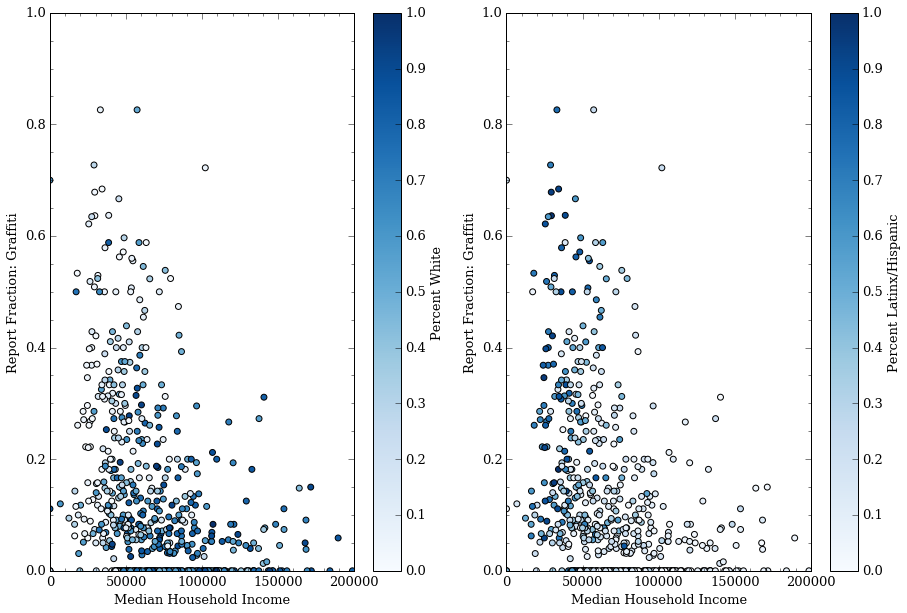

In [162]:
fig, test = plt.subplots(1,2, figsize=(15,10))
fig.subplots_adjust(hspace=.5)
fig.subplots_adjust(wspace=.2)

cs = test[0].scatter(census_combo.loc[np.where(census_combo['count']>=10)[0], 'median_house_income'].astype(int),
            census_combo.loc[np.where(census_combo['count']>=10)[0], 'graffiti_per'],
            c=census_combo.loc[np.where(census_combo['count']>=10)[0], 'white_per'], 
            cmap='Blues', s=35)
test[0].set_xlim(-0.0001,200000)
test[0].set_ylim(0,1.0)
test[0].minorticks_on()
cb=plt.colorbar(cs, label='Percent White', ax=test[0])

cs2 = test[1].scatter(census_combo.loc[np.where(census_combo['count']>=10)[0], 'median_house_income'].astype(int),
            census_combo.loc[np.where(census_combo['count']>=10)[0], 'graffiti_per'],
            c=census_combo.loc[np.where(census_combo['count']>=10)[0], 'latin_per'], 
            cmap='Blues', s=35)
test[1].set_xlim(-0.0001,200000)
test[1].set_ylim(0,1.0)
test[1].minorticks_on()

cb=plt.colorbar(cs2, label='Percent Latinx/Hispanic', ax=test[1])

test[0].set_xlabel('Median Household Income')
test[0].set_ylabel('Report Fraction: Graffiti')
test[1].set_xlabel('Median Household Income')
test[1].set_ylabel('Report Fraction: Graffiti')

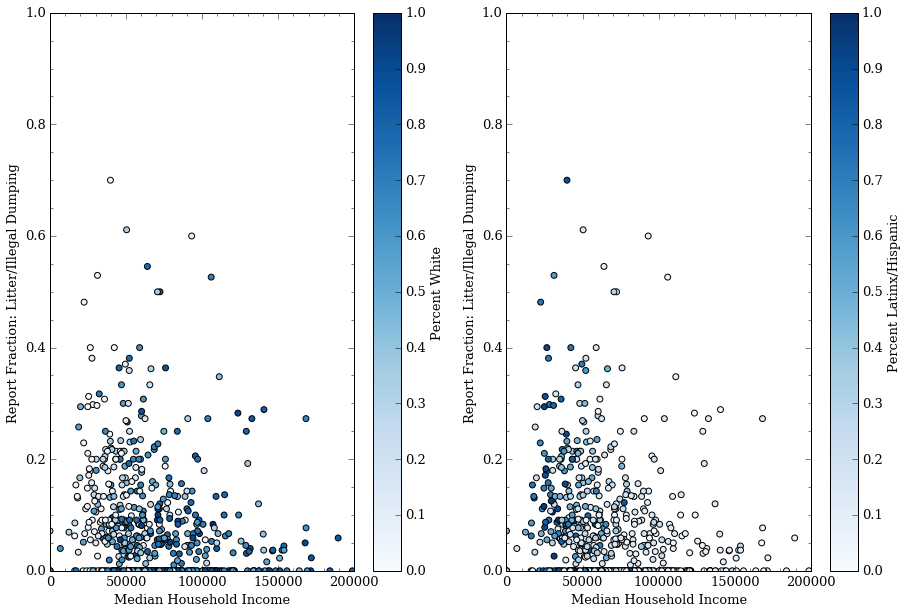

In [163]:
fig, test = plt.subplots(1,2, figsize=(15,10))
fig.subplots_adjust(hspace=.5)
fig.subplots_adjust(wspace=.2)

cs = test[0].scatter(census_combo.loc[np.where(census_combo['count']>=10)[0], 'median_house_income'].astype(int),
            census_combo.loc[np.where(census_combo['count']>=10)[0], 'dump_per'],
            c=census_combo.loc[np.where(census_combo['count']>=10)[0], 'white_per'], 
            cmap='Blues', s=35)
test[0].set_xlim(-0.0001,200000)
test[0].set_ylim(0,1.0)
test[0].minorticks_on()
cb=plt.colorbar(cs, label='Percent White', ax=test[0])

cs2 = test[1].scatter(census_combo.loc[np.where(census_combo['count']>=10)[0], 'median_house_income'].astype(int),
            census_combo.loc[np.where(census_combo['count']>=10)[0], 'dump_per'],
            c=census_combo.loc[np.where(census_combo['count']>=10)[0], 'latin_per'], 
            cmap='Blues', s=35)
test[1].set_xlim(-0.0001,200000)
test[1].set_ylim(0,1.0)
test[1].minorticks_on()

cb=plt.colorbar(cs2, label='Percent Latinx/Hispanic', ax=test[1])

test[0].set_xlabel('Median Household Income')
test[0].set_ylabel('Report Fraction: Litter/Illegal Dumping')
test[1].set_xlabel('Median Household Income')
test[1].set_ylabel('Report Fraction: Litter/Illegal Dumping')

In [1]:
plt.hist(census_big['median_age_latin'].astype(float), bins=20, range=[0,100], histtype='step')
plt.hist(census_big['median_age_white'].astype(float), bins=20, range=[0,100], histtype='step')

NameError: name 'plt' is not defined

In [598]:
vomit.loc[np.where(np.isnan(vomit['Age (Days)'])==True)[0], 'Age (Days)'] = 0.0

32


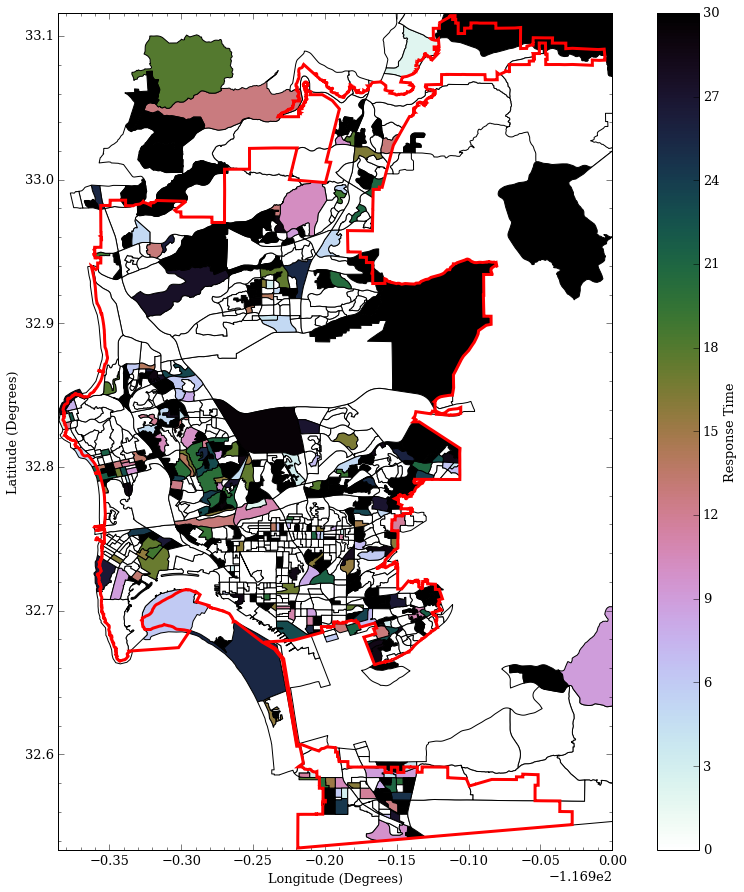

In [108]:
column_choice = 'Age (Days)'
#column_choice = 'Estimate; Total'

p1 = Proj("+init=EPSG:2230", preserve_units=True)

fig,ax = plt.subplots(1,1, figsize=(20,15))
patches = []
for i in range(0,len(sdcounty_index)): 
    if (len(np.where(sd_city_proper['tract'] == sdcounty.loc[sdcounty_index[i], 'tract'])[0])>0): 
        barf = pd.DataFrame(shapes[sdcounty_index[i]].points)
        poly = plt.Polygon(barf[[0,1]], fc='none', ec='k', alpha=0.7)
        patches.append(poly)

colors = vomit[column_choice]
p = PatchCollection(patches, cmap='cubehelix_r', alpha=1.0)
p.set_array(np.array(colors))
#p.set_clim([min(colors),max(colors)])
#p.set_clim([min(colors),0.15])
p.set_clim([min(colors),30])


ax.add_collection(p)

patches1 = []
for i in range(32,33): 
    print i
    temp = pd.DataFrame(mc_shapes[i].points)
    lon, lat = p1(np.array(temp.loc[0:33632, 0]), np.array(temp.loc[0:33632, 1]), inverse=True)
    poly = plt.Polygon(np.transpose([lon,lat]), fc='none', ec='red', alpha=1.0, lw=3.0, zorder=3)
    patches1.append(poly)
    plt.gca().add_patch(poly)

plt.axis('scaled')
plt.minorticks_on()

plt.colorbar(p, fraction=0.046, pad=0.04, shrink=1.0, label='Response Time')

plt.ylim(32.533541,33.116178)
plt.xlim(-117.285629,-116.9)
plt.xlabel('Longitude (Degrees)')
plt.ylabel('Latitude (Degrees)')

#plt.savefig('output_figures/rep_per_cap_map.eps')

plt.show()
#mpld3.display()

32


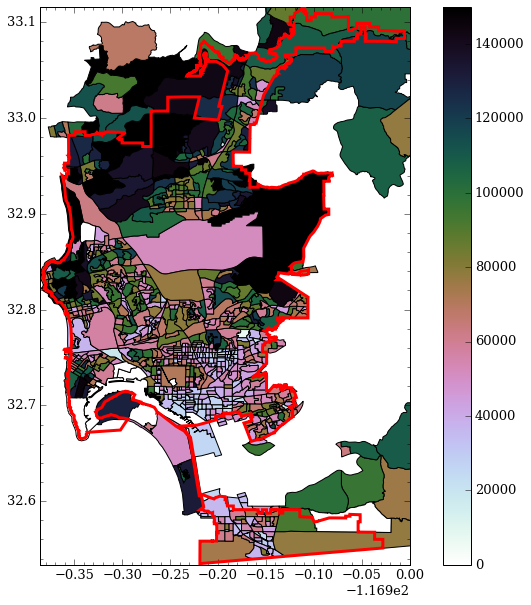

In [110]:
column_choice = 'median_house_income'
#column_choice = 'Estimate; Total'

p1 = Proj("+init=EPSG:2230", preserve_units=True)

fig,ax = plt.subplots(1,1, figsize=(15,10))
patches = []
col_values = []
for i in range(0,len(sdcounty_index)): 
    if (len(np.where(sd_city_proper['tract'] == sdcounty.loc[sdcounty_index[i], 'tract'])[0])>0): 
        col_values.append(census_big.loc[i, column_choice])
        barf = pd.DataFrame(shapes[sdcounty_index[i]].points)
        poly = plt.Polygon(barf[[0,1]], fc='none', ec='k', alpha=0.7)
        patches.append(poly)

colors = col_values
p = PatchCollection(patches, cmap='cubehelix_r', alpha=1.0)
p.set_array(np.array(colors))
#p.set_clim([min(colors),max(colors)])
p.set_clim([min(colors),150000])

ax.add_collection(p)

patches1 = []
for i in range(32,33): 
    print i
    temp = pd.DataFrame(mc_shapes[i].points)
    lon, lat = p1(np.array(temp.loc[0:33632, 0]), np.array(temp.loc[0:33632, 1]), inverse=True)
    poly = plt.Polygon(np.transpose([lon,lat]), fc='none', ec='red', alpha=1.0, lw=3.0, zorder=3)
    patches1.append(poly)
    plt.gca().add_patch(poly)

plt.axis('scaled')
plt.minorticks_on()

plt.colorbar(p, fraction=0.046, pad=0.04, shrink=1.0, label='')

plt.ylim(32.533541,33.116178)
plt.xlim(-117.285629,-116.9)
#plt.xlabel('Longitude (Degrees)')
#plt.ylabel('Latitude (Degrees)')

#plt.savefig('output_figures/graffiti_per_map.eps')

plt.show()
#mpld3.display()

In [398]:
#np.where(np.isfinite(census_big['median_house_income'].astype(int))==False)

(array([], dtype=int64),)

### To define my training set: 
- want an even distribution of graffiti rich and poor areas 
- only include areas with some threshold of reports
- think about things in terms of recall/precision rather than accuracy (because have many many more graffiti poor than graffiti rich areas)

### Experiment with linear regression models

In [111]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import random 

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

/Users/kschles/anaconda/lib/python2.7/site-packages/numpy/lib/utils.py:99: DeprecationWarning: `scipy.linalg.calc_lwork` is deprecated!

calc_lwork was an internal module in Scipy and has been removed.

Several functions in scipy.linalg.lapack have *_lwork variants
that perform the lwork calculation (from Scipy >= 0.15.0), or
allow passing in LWORK=-1 argument to perform the computation.


  warnings.warn(depdoc, DeprecationWarning)


Standardize each column 
#### ACCORDING TO JEFF, JENN SAYS WE DON'T NEED TO WORRY ABOUT THIS RIGHT NOW BECAUSE WE'RE NOT REGULARIZING

In [167]:
"""
census_standard = pd.DataFrame()

yak = StandardScaler().fit_transform(census_big[['latin_per', 'white_per', 'median_house_income', 'rep_per_cap', 
                                                'Estimate; Total']])
census_standard['latin_per'] = yak[:,0]
census_standard['white_per'] = yak[:,1]
census_standard['median_house_income'] = yak[:,2]
census_standard['rep_per_cap'] = yak[:,3]
census_standard['total_pop'] = yak[:,4]
census_standard['graffiti_per'] = census_big['graffiti_per']
"""
print 'see comment in markdown above'

see comment in markdown above


#### Start with a binary definition of graffiti rich/poor 
Graffiti rich if: 
- at least 50 reports
- More than 50% of reports are graffiti-related

In [112]:
report_limit = 5
graffiti_threshold = 0.60

### Training sample:
- select 20 graffiti rich regions (out of 94)
- select 20 graffiti poor regions (each with more than 10 reports in total)

In [437]:
#census_big.rename(columns={'Estimate; Total': 'total_pop'}, inplace=True)

In [113]:
grich_index = np.where((census_big['count']>=report_limit) 
                        & (census_big['graffiti_per']>=graffiti_threshold))[0]
gpoor_index = np.where((census_big['count']>=report_limit) 
                        & (census_big['graffiti_per']<graffiti_threshold))[0]

len(grich_index), len(gpoor_index)

(14, 726)

In [114]:
# Select a random sample of graffiti poor areas to test on. Same number as graffiti rich.
poor_train_index = [random.randint(0,len(gpoor_index)-1) for p in range(0,len(grich_index))]

# Extract graffiti rich and graffiti poor areas
rich = census_big.loc[grich_index]
poor = census_big.loc[gpoor_index[poor_train_index]]

# Create training set from extracted material 
training_set = pd.concat([rich, poor])
training_set.reset_index(drop=True,inplace=True)

# Create a test set from material not in the training set. 

test_index = []
for i in range(0, len(census_big)): 
    if ((i not in grich_index) & (i not in gpoor_index[poor_train_index])):
            if (census_big.loc[i, 'count']>=10): 
                test_index.append(i)
                
test_set = census_big.loc[test_index]
test_set.reset_index(drop=True, inplace=True)

In [115]:
len(training_set), len(test_set)

(28, 550)

Baseline model based on reports per capita: 

In [233]:
fml = 'graffiti_per ~ rep_per_cap'

In [234]:
model = smf.ols(fml, training_set).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           graffiti_per   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     2.253
Date:                Fri, 16 Sep 2016   Prob (F-statistic):              0.145
Time:                        11:45:53   Log-Likelihood:                -6.9300
No. Observations:                  28   AIC:                             17.86
Df Residuals:                      26   BIC:                             20.52
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       0.3244      0.078      4.161      

In [235]:
test_labels = model.predict(test_set)
train_labels_test = model.predict(training_set)
census_labels = model.predict(census_big)

/Users/kschles/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:739: DeprecationWarning: The DesignInfo.builder attribute is deprecated starting in patsy v0.4.0; distinct builder objects have been eliminated and design_info.builder is now just a long-winded way of writing 'design_info' (i.e. the .builder attribute just returns self)
  exog = dmatrix(self.model.data.orig_exog.design_info.builder,
/Users/kschles/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:739: DeprecationWarning: The DesignInfo.builder attribute is deprecated starting in patsy v0.4.0; distinct builder objects have been eliminated and design_info.builder is now just a long-winded way of writing 'design_info' (i.e. the .builder attribute just returns self)
  exog = dmatrix(self.model.data.orig_exog.design_info.builder,
/Users/kschles/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:739: DeprecationWarning: The DesignInfo.builder attribute is deprecated starting in patsy v0.4.0

In [244]:
# Calculate recall score
gscore = np.array(census_big['graffiti_per'])
counter = np.array(census_big['count'])

gr_index = np.where((gscore>=0.6) & (counter>=10))[0]
gp_index = np.where((gscore<0.6) & (counter>=10))[0]
gnone_index = np.where(counter<10)[0]

gscore[gr_index] = 1.0
gscore[gp_index] = 0.0
gscore[gnone_index] = -1.0

# Split prediction rates into binary coding as well. 
predicted_gscore = np.array(census_labels)

pgr_index = np.where((predicted_gscore>=0.6) & (counter>=10))[0]
pgp_index = np.where((predicted_gscore<0.6) & (counter>=10))[0]
pnone_index = np.where(counter<10)[0]

predicted_gscore[pgp_index] = 0.0
predicted_gscore[pgr_index] = 1.0
predicted_gscore[pnone_index] = -1.0

gscore_ed = gscore[np.where(gscore>-1)[0]]
predicted_gscore_ed = predicted_gscore[np.where(gscore>-1)[0]]

len(gscore), len(gscore_ed), len(predicted_gscore_ed)

print recall_score(gscore_ed, predicted_gscore_ed, pos_label=1)
print precision_score(gscore_ed, predicted_gscore_ed, pos_label=1)

0.166666666667
0.166666666667


(0.0, 0.89)

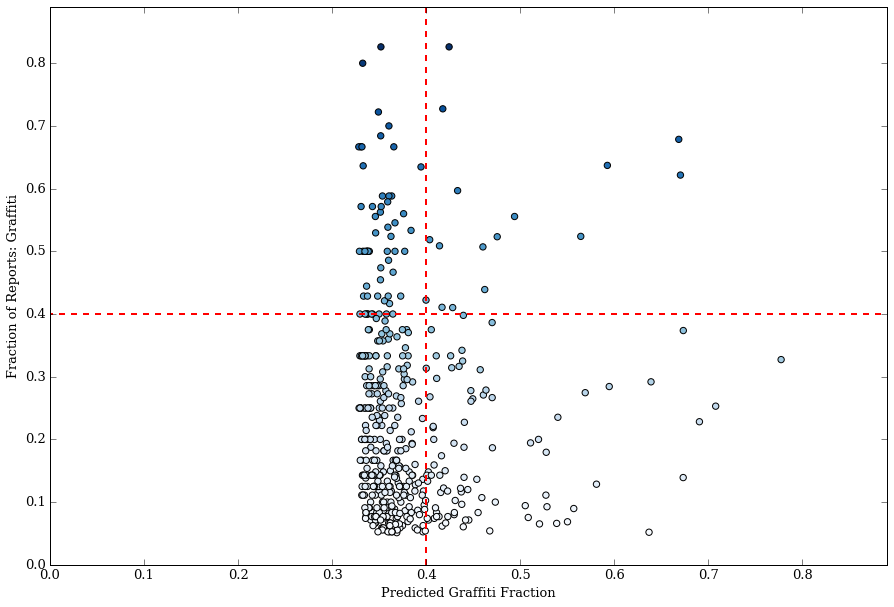

In [243]:
fig, test = plt.subplots(1,1, figsize=(15,10))
fig.subplots_adjust(hspace=.5)
fig.subplots_adjust(wspace=.2)

cs = test.scatter(census_labels[np.where((census_labels<=1.0) 
                                            & (census_big['graffiti_per']>0.05) 
                                            & (census_big['graffiti_per']<1.))[0]], 
                     census_big.loc[np.where((census_labels<=1.0) 
                                             & (census_big['graffiti_per']>0.05) 
                                             & (census_big['graffiti_per']<1.))[0], 
                                    'graffiti_per'], 
                     c=census_big.loc[np.where((census_labels<=1.0) 
                                               & (census_big['graffiti_per']>0.05) 
                                               & (census_big['graffiti_per']<1.))[0], 
                                      'graffiti_per'], cmap='Blues', 
                 s=40)

test.set_xlabel('Predicted Graffiti Fraction')
test.set_ylabel('Fraction of Reports: Graffiti')
#test.plot([0,1.0],[0,1.0], 'r--', lw=2)
test.plot([0.4,0.4],[0.0,1.0], 'r--', lw=2)
test.plot([-0.2,1.0],[0.4,0.4], 'r--', lw=2)

test.set_ylim(0.0,0.89)
test.set_xlim(0.0,0.89)

#test.axis('scaled')

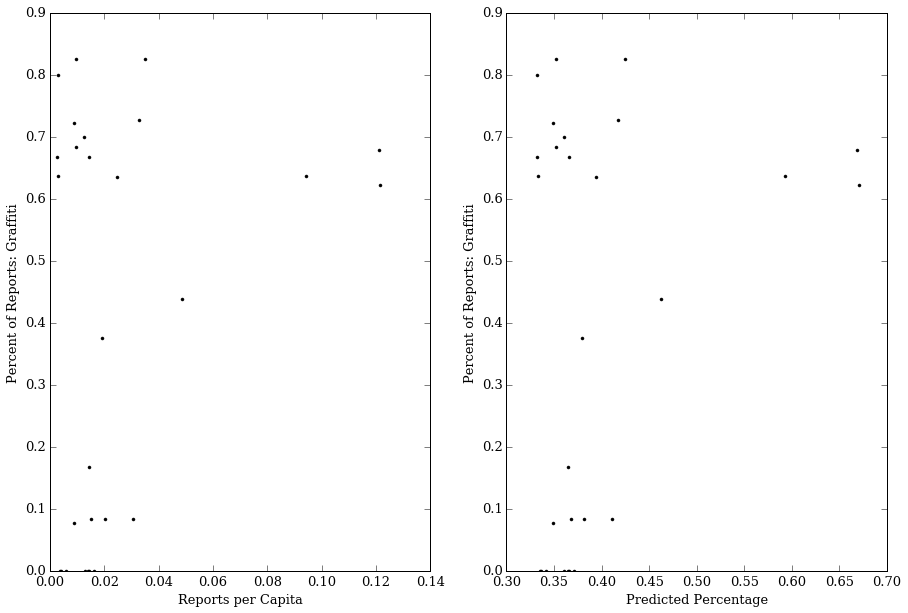

In [119]:
fig, test = plt.subplots(1,2, figsize=(15,10))
fig.subplots_adjust(hspace=.5)
fig.subplots_adjust(wspace=.2)

test[0].plot(training_set['rep_per_cap'], training_set['graffiti_per'], 'k.')
test[0].set_xlabel('Reports per Capita')
test[0].set_ylabel('Percent of Reports: Graffiti')

test[1].plot(train_labels_test,training_set['graffiti_per'], 'k.')
test[1].set_xlabel('Predicted Percentage')
test[1].set_ylabel('Percent of Reports: Graffiti')
#test[1].plot([0,1.0],[0,1.0], 'r--')
#test[1].set_xlim(0.22,0.4)



Now add in other features to the model to improve the accuracy.

In [250]:
training_set.columns.values

array(['tract', 'blockgroup', 'count', 'graffiti_count', 'dump_count',
       'lighting_count', 'sl_count', 'landarea', 'cent_lat', 'cent_lon',
       'sl_density', 'gsl_meandist', 'dsl_meandist', 'total_pop',
       'rep_per_cap', 'graffiti_per', 'dump_per', 'lighting_per',
       'male_5_17', 'male_18_29', 'male_30_60', 'male_61plus',
       'female_5_17', 'female_18_29', 'female_30_60', 'female_61plus',
       'rent_0_500', 'rent_501_1000', 'rent_1000plus', 'income_0_25',
       'income_25_50', 'income_50_100', 'income_100_150', 'income_150plus',
       'white_per', 'baa_per', 'aian_per', 'asian_per', 'pi_per',
       'other_per', 'tp_per', 'latin_per', 'publica_per', 'ownerocc_per',
       'median_house_income', 'median_structure_year', 'median_home_value'], dtype=object)

In [246]:
fml = 'graffiti_per ~ white_per + median_house_income + asian_per'
#fml = 'graffiti_per ~ latin_per + median_house_income'

In [247]:
model = smf.ols(fml, training_set).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           graffiti_per   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     9.594
Date:                Fri, 16 Sep 2016   Prob (F-statistic):           0.000240
Time:                        11:50:52   Log-Likelihood:                 2.9402
No. Observations:                  28   AIC:                             2.120
Df Residuals:                      24   BIC:                             7.448
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept               0.7886    

In [129]:
np.where(np.isnan(test_set[['rep_per_cap', 'median_house_income', 'latin_per']])==True)

(array([], dtype=int64), array([], dtype=int64))

In [151]:
#census_big.loc[np.where(np.isnan(census_big['graffiti_per'])==True)[0], 'graffiti_per'] = -1.0

In [130]:
#census_big.loc[np.where(np.isnan(census_big['graffiti_per'])==True)[0], 'graffiti_per'] = 0.0
#census_big.loc[np.where(np.isnan(census_big['lighting_per'])==True)[0], 'lighting_per'] = 0.0

In [248]:
test_labels = model.predict(test_set)
train_labels_test = model.predict(training_set)
census_labels = model.predict(census_big)

/Users/kschles/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:739: DeprecationWarning: The DesignInfo.builder attribute is deprecated starting in patsy v0.4.0; distinct builder objects have been eliminated and design_info.builder is now just a long-winded way of writing 'design_info' (i.e. the .builder attribute just returns self)
  exog = dmatrix(self.model.data.orig_exog.design_info.builder,
/Users/kschles/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:739: DeprecationWarning: The DesignInfo.builder attribute is deprecated starting in patsy v0.4.0; distinct builder objects have been eliminated and design_info.builder is now just a long-winded way of writing 'design_info' (i.e. the .builder attribute just returns self)
  exog = dmatrix(self.model.data.orig_exog.design_info.builder,
/Users/kschles/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:739: DeprecationWarning: The DesignInfo.builder attribute is deprecated starting in patsy v0.4.0

In [139]:
len(test_labels), len(test_set), len(train_labels_test), len(training_set), len(census_labels), len(census_big)

(550, 550, 28, 28, 1794, 1794)

In [570]:
#barf = pd.DataFrame()
#barf['true'] = census_big['graffiti_per']
#barf['predicted'] = census_labels

('R2 Training: ', 0.54530481131435149)
('R2 Test: ', -1.4871088616445678)
('R2 Test (remove non-physical): ', -2.1487730951661019)


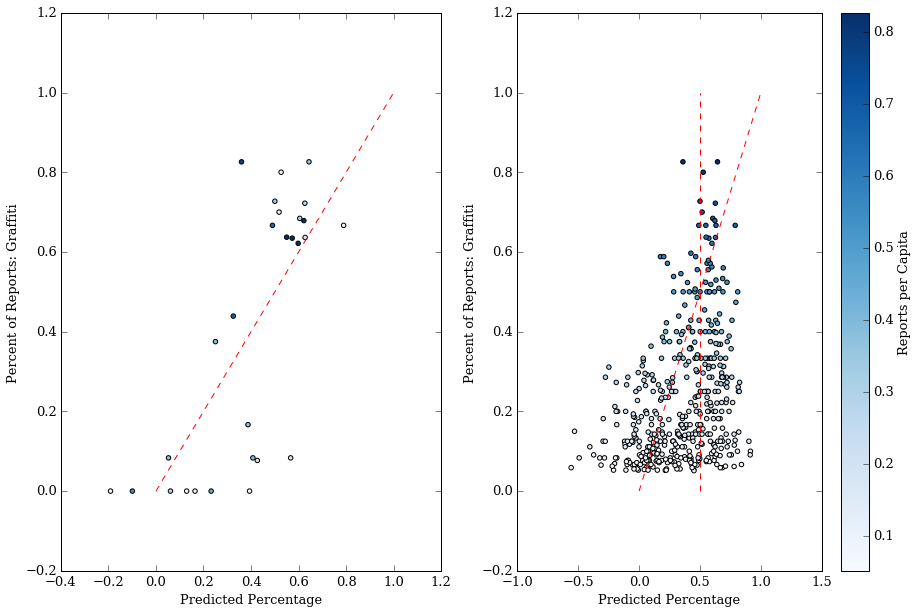

In [249]:
fig, test = plt.subplots(1,2, figsize=(15,10))
fig.subplots_adjust(hspace=.5)
fig.subplots_adjust(wspace=.2)

test[0].scatter(train_labels_test, training_set['graffiti_per'], c=training_set['count'], cmap='Blues', vmax=50)
test[0].set_xlabel('Predicted Percentage')
test[0].set_ylabel('Percent of Reports: Graffiti')
test[0].plot([0,1.0],[0,1.0], 'r--')

#cs = test[1].scatter(test_labels,test_set['graffiti_per'], c=test_set['count'], cmap='Blues', vmax=50)
#cb = plt.colorbar(cs,ax=test[1], label='Reports per Capita')
#test[1].set_xlabel('Predicted Percentage')
#test[1].set_ylabel('Percent of Reports: Graffiti')
#test[1].plot([0,1.0],[0,1.0], 'r--')

#cs = test[1].scatter(census_labels,census_big['graffiti_per'], c=census_big['count'], cmap='Blues', vmax=50)
cs = test[1].scatter(census_labels[np.where((census_labels<=1.0) 
                                            & (census_big['graffiti_per']>0.05) 
                                            & (census_big['graffiti_per']<1.))[0]], 
                     census_big.loc[np.where((census_labels<=1.0) 
                                             & (census_big['graffiti_per']>0.05) 
                                             & (census_big['graffiti_per']<1.))[0], 
                                    'graffiti_per'], 
                     c=census_big.loc[np.where((census_labels<=1.0) 
                                               & (census_big['graffiti_per']>0.05) 
                                               & (census_big['graffiti_per']<1.))[0], 
                                      'graffiti_per'], cmap='Blues')




cb = plt.colorbar(cs,ax=test[1], label='Reports per Capita')
test[1].set_xlabel('Predicted Percentage')
test[1].set_ylabel('Percent of Reports: Graffiti')
test[1].plot([0,1.0],[0,1.0], 'r--')
test[1].plot([0.5,0.5],[0.0,1.0], 'r--')

print('R2 Training: ', r2_score(training_set['graffiti_per'],train_labels_test))

#print('R2 Test: ', r2_score(test_set['graffiti_per'],test_labels))
#print('R2 Test (remove non-physical): ', r2_score(test_set.loc[np.where(test_labels<=1.0)[0], 'graffiti_per'], 
#                                                 test_labels[np.where(test_labels<=1.0)[0]]))

print('R2 Test: ', r2_score(census_big['graffiti_per'],census_labels))
print('R2 Test (remove non-physical): ', r2_score(census_big.loc[np.where((census_labels<=1.0) & (census_labels>0) & (census_big['graffiti_per']>0.05) & (census_big['graffiti_per']<1.))[0], 'graffiti_per'], 
                                                 census_labels[np.where((census_labels<=1.0) & (census_labels>0) & (census_big['graffiti_per']>0.05) & (census_big['graffiti_per']<1.))[0]]))



Recall/Precision scores

In [232]:
from sklearn.metrics import recall_score, precision_score

In [252]:
# Calculate recall score
gscore = np.array(census_big['graffiti_per'])
counter = np.array(census_big['count'])

gr_index = np.where((gscore>=0.4) & (counter>=10))[0]
gp_index = np.where((gscore<0.4) & (counter>=10))[0]
gnone_index = np.where(counter<10)[0]

gscore[gr_index] = 1.0
gscore[gp_index] = 0.0
gscore[gnone_index] = -1.0

# Split prediction rates into binary coding as well. 
predicted_gscore = np.array(census_labels)

pgr_index = np.where((predicted_gscore>=0.4) & (counter>=10))[0]
pgp_index = np.where((predicted_gscore<0.4) & (counter>=10))[0]
pnone_index = np.where(counter<10)[0]

predicted_gscore[pgp_index] = 0.0
predicted_gscore[pgr_index] = 1.0
predicted_gscore[pnone_index] = -1.0

gscore_ed = gscore[np.where(gscore>-1)[0]]
predicted_gscore_ed = predicted_gscore[np.where(gscore>-1)[0]]

len(gscore), len(gscore_ed), len(predicted_gscore_ed)

print recall_score(gscore_ed, predicted_gscore_ed, pos_label=1)
print precision_score(gscore_ed, predicted_gscore_ed, pos_label=1)

0.781818181818
0.205741626794


(-0.2, 0.89)

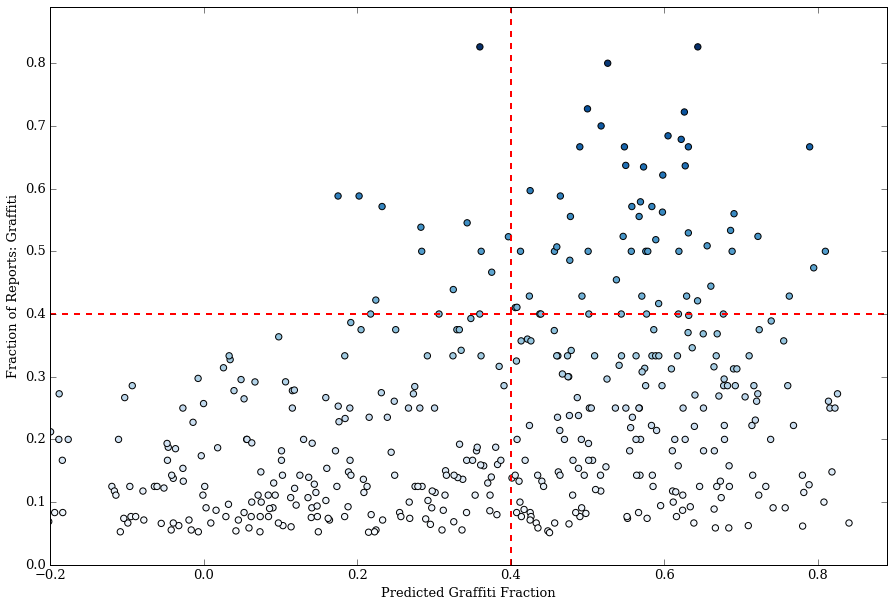

In [253]:
fig, test = plt.subplots(1,1, figsize=(15,10))
fig.subplots_adjust(hspace=.5)
fig.subplots_adjust(wspace=.2)

cs = test.scatter(census_labels[np.where((census_labels<=1.0) 
                                            & (census_big['graffiti_per']>0.05) 
                                            & (census_big['graffiti_per']<1.))[0]], 
                     census_big.loc[np.where((census_labels<=1.0) 
                                             & (census_big['graffiti_per']>0.05) 
                                             & (census_big['graffiti_per']<1.))[0], 
                                    'graffiti_per'], 
                     c=census_big.loc[np.where((census_labels<=1.0) 
                                               & (census_big['graffiti_per']>0.05) 
                                               & (census_big['graffiti_per']<1.))[0], 
                                      'graffiti_per'], cmap='Blues', 
                 s=40)

test.set_xlabel('Predicted Graffiti Fraction')
test.set_ylabel('Fraction of Reports: Graffiti')
#test.plot([0,1.0],[0,1.0], 'r--', lw=2)
test.plot([0.4,0.4],[0.0,1.0], 'r--', lw=2)
test.plot([-0.2,1.0],[0.4,0.4], 'r--', lw=2)

test.set_ylim(0.0,0.89)
test.set_xlim(-0.2,0.89)

#test.axis('scaled')

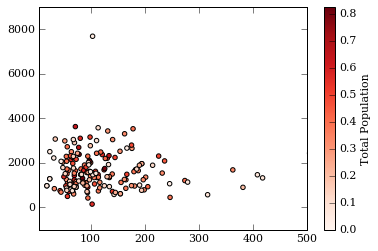

In [1389]:
plt.scatter(training_set['gsl_meandist'], training_set['total_pop'], c=training_set['graffiti_per'], cmap='Reds', )
plt.xlim(5,500)
plt.colorbar(label='Total Population')

In [600]:
# Trim both samples down to the columns you want to start with
# Here i'm just starting with information on street lights
training_set_ed = training_set[['white_per', 'baa_per', 'asian_per',
       'other_per', 'latin_per']]
test_set_ed = test_set[['white_per', 'baa_per', 'asian_per', 
       'other_per', 'latin_per']]

training_set_ed.reset_index(drop=True, inplace=True)
test_set_ed.reset_index(drop=True, inplace=True)

In [385]:
#np.where(np.isfinite(test_set_ed)==False)

In [601]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(training_set_ed)
Y = StandardScaler().fit_transform(test_set_ed)

In [469]:
#log_labels = np.log10(training_set['graffiti_per'])
#log_labels[np.where(np.isfinite(np.log10(training_set['graffiti_per']))==False)[0]]= 0.0

#test_log_labels = np.log10(test_set['graffiti_per'])
#test_log_labels[np.where(np.isfinite(test_log_labels)==False)[0]]= 0.0

In [602]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
clf = regr.fit(X, training_set['grich'])

In [603]:
clf.coef_

array([ 0.55168445,  0.10810653,  0.15043785, -0.05050325,  0.82646539])

In [604]:
test_labels = clf.predict(Y)

In [537]:
from sklearn.metrics import recall_score, r2_score
from scipy import stats


In [606]:
barf = test_labels 
barf[np.where(barf>=0.5)] = 1.0
barf[np.where(barf<0.5)] = 0.0

In [607]:
r2_score(test_set['grich'], barf)

-16.653846153846153

In [608]:
recall_score(test_set['grich'], barf)

1.0

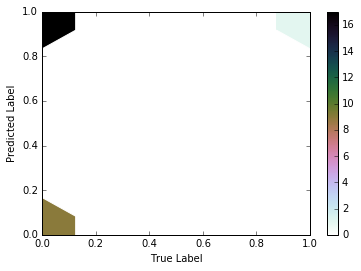

In [609]:
plt.hexbin(test_set['grich'], barf, gridsize=4, cmap='cubehelix_r')
plt.colorbar()
plt.xlabel('True Label')
plt.ylabel('Predicted Label')

r-squared: 0.124217102499


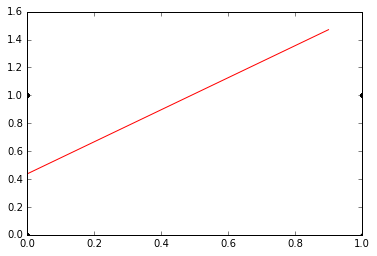

In [494]:
plt.plot(test_set['grich'], barf, 'k.')
#plt.plot(np.array(test_log_labels), test_labels, 'k.')


#slope, intercept, r_value, p_value, std_err = stats.linregress(test_log_labels, test_labels)
slope, intercept, r_value, p_value, std_err = stats.linregress(test_set['graffiti_per'], test_labels)

print "r-squared:", r_value**2

xer = np.arange(0.0,1.0, 0.1)
plt.plot(xer, slope*xer + intercept, 'r-')

In [267]:
test_set_ed.describe()

,sl_density,gsl_meandist
count,537.000000,5.370000e+02
mean,0.000131,3.897245e+04
std,0.000152,5.284304e+05
min,0.000000,0.000000e+00
25%,0.000063,0.000000e+00
50%,0.000098,6.978012e+01
75%,0.000146,1.196431e+02
max,0.001408,1.014095e+07


In [264]:
test_set.columns.values

array(['tract', 'blockgroup', 'count', 'graffiti_count', 'dump_count',
       'lighting_count', 'sl_count', 'landarea', 'cent_lat', 'cent_lon',
       'sl_density', 'gsl_meandist', 'dsl_meandist', 'Estimate; Total',
       'rep_per_cap', 'graffiti_per', 'dump_per', 'lighting_per',
       'male_5_17', 'male_18_29', 'male_30_60', 'male_61plus',
       'female_5_17', 'female_18_29', 'female_30_60', 'female_61plus',
       'rent_0_500', 'rent_501_1000', 'rent_1000plus', 'income_0_25',
       'income_25_50', 'income_50_100', 'income_100_150', 'income_150plus',
       'white_per', 'baa_per', 'aian_per', 'asian_per', 'pi_per',
       'other_per', 'tp_per', 'latin_per', 'publica_per', 'ownerocc_per',
       'grich'], dtype=object)

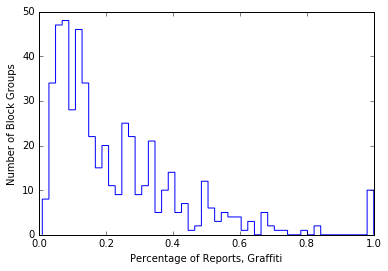

In [212]:
a = plt.hist(census_big['graffiti_per'], bins=50, range=[0.01,1.0], histtype='step')
plt.xlabel('Percentage of Reports, Graffiti')
plt.ylabel('Number of Block Groups')

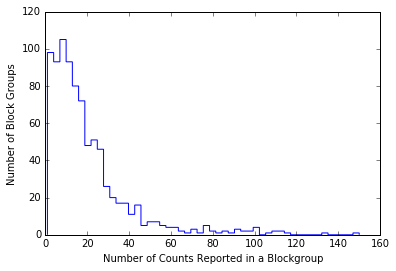

In [213]:
# Note that this includes block groups outside of San Diego city
a = plt.hist(census_big['count'], bins=50, range=[1,150], histtype='step')
plt.xlabel('Number of Counts Reported in a Blockgroup')
plt.ylabel('Number of Block Groups')

In [129]:
#for i in census_numeric.columns.values: 
#    census_numeric.loc[np.where(np.isnan(census_numeric[i])==True)[0], i] = 0.0

In [204]:
np.shape(census_big)

(1794, 44)

In [113]:
# If there are no reports, set counts to 0. 
for i in total_reports_demo.columns.values: 
    total_reports_demo.loc[np.where(np.isnan(total_reports_demo[i])==True)[0], i] = 0.0

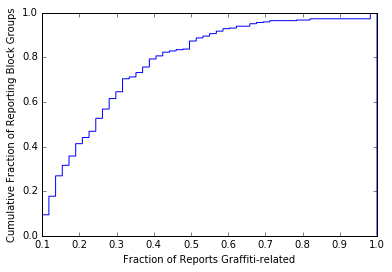

In [114]:
plt.hist(total_reports_demo['graffiti_per'], bins=50, range=[0.1,1.], histtype='step', cumulative=True, normed=True)
plt.xlabel('Fraction of Reports Graffiti-related')
plt.ylabel('Cumulative Fraction of Reporting Block Groups')

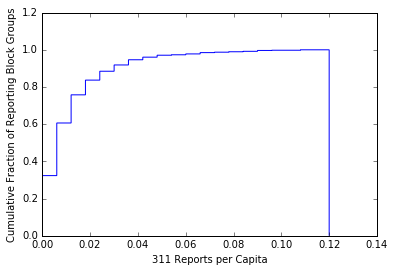

In [115]:
plt.hist(total_reports_demo.loc[np.where(total_reports_demo['rep_per_cap']!=0)[0], 
                                'rep_per_cap'], bins=20, histtype='step', 
         cumulative=True, normed=True, range=[0.0001,0.12])
plt.xlabel('311 Reports per Capita')
plt.ylabel('Cumulative Fraction of Reporting Block Groups')

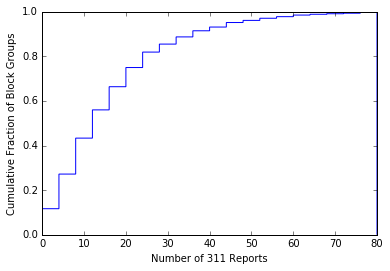

In [116]:
plt.hist(total_reports_demo.loc[np.where(total_reports_demo['count']!=0)[0], 
                                'count'], bins=20, histtype='step', range=[0,80], 
                                cumulative=True, normed=True)
plt.xlabel('Number of 311 Reports')
plt.ylabel('Cumulative Fraction of Block Groups')

In [498]:
# 95% of block groups have a report per capita 
np.percentile(total_reports_demo.loc[np.where(total_reports_demo['rep_per_cap']!=0)[0], 
                                     'rep_per_cap'],5)

0.001060742871662704

Can see that dumping events are typically farther from a street light than graffiti events. Both are typically >50 feet from a light.

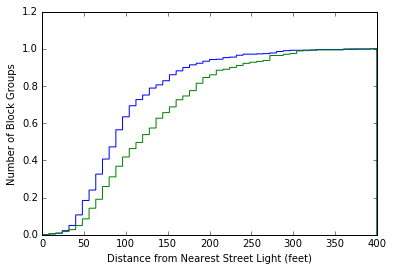

In [37]:
temp = plt.hist(sdcounty_only_requests['gsl_meandist'], bins=50, histtype='step', 
                range=[0,400], cumulative=True, normed=True)
temp = plt.hist(sdcounty_only_requests['dsl_meandist'], bins=50, histtype='step', 
                range=[0,400], cumulative=True, normed=True)
plt.xlabel('Distance from Nearest Street Light (feet)')
plt.ylabel('Number of Block Groups')

Shapefile reader for San Diego city proper

In [38]:
mc_reader = sf.Reader('shapefiles/Municipal_Boundaries/MUNICIPAL_BOUNDARIES.shp')
mc_records = pd.DataFrame(mc_reader.records())
mc_shapes = mc_reader.shapes()

mc_records_index = np.where(mc_records[1]=='SD')

32


(-117.3, -116.90000000000001, 32.5, 33.200000000000003)

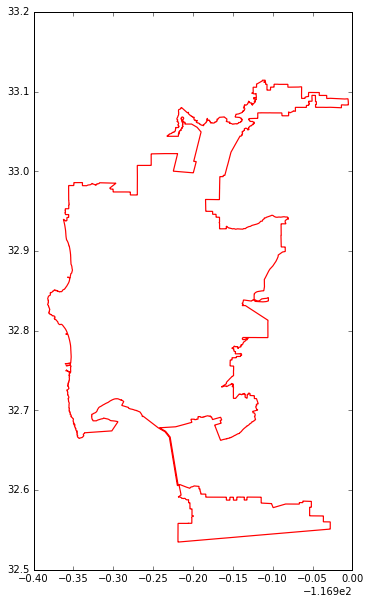

In [39]:
fig,ax = plt.subplots(1,1, figsize=(10,10))
patches1 = []
for i in range(32,33): 
    print i
    temp = pd.DataFrame(mc_shapes[i].points)
    lon, lat = p1(np.array(temp.loc[0:33632, 0]), np.array(temp.loc[0:33632, 1]), inverse=True)
    poly = plt.Polygon(np.transpose([lon,lat]), fc='none', ec='r', alpha=1.0, lw=1.2, zorder=3)
    patches1.append(poly)
    plt.gca().add_patch(poly)

plt.axis('scaled')

In [1014]:
po_reader = sf.Reader('shapefiles/SDPD_BEATS/SDPD_BEATS.shp')
po_records = pd.DataFrame(po_reader.records())
po_shapes = po_reader.shapes()

In [1027]:
mc_reader = sf.Reader('shapefiles/Municipal_Boundaries/MUNICIPAL_BOUNDARIES.shp')
mc_records = pd.DataFrame(mc_reader.records())
mc_shapes = mc_reader.shapes()

mc_records_index = np.where(mc_records[1]=='SD')

In [1029]:
mc_records_index = np.where(mc_records[1]=='SD')

In [1159]:
for i in range(0,3): 
    #if sdcounty.loc[sdcounty_index[i], 'tract'] in list(sdcity_census_tracts):
    temp_tract = sdcounty.loc[sdcounty_index[i], 'tract']
    temp_bg = sdcounty.loc[sdcounty_index[i], 'blockgroup']
    if (len(np.where((yak['tract']==temp_tract) & (yak['blockgroup']==temp_bg))[0])==1): 
        print np.where((yak['tract']==temp_tract) & (yak['blockgroup']==temp_bg))[0]


[735]
[741]
[743]


In [1158]:
temp_tract, temp_bg

('010104', '2')

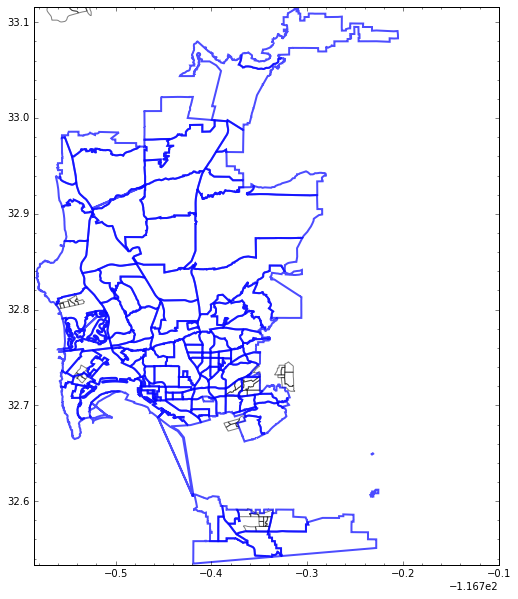

In [1598]:
fig,ax = plt.subplots(1,1, figsize=(10,10))

# Block Groups
patches = []
for i in range(0,len(sdcounty_index)): 
    if sdcounty.loc[sdcounty_index[i], 'tract'] in list(sdcity_census_tracts):
    #temp_tract = sdcounty.loc[sdcounty_index[i], 'tract']
    #temp_bg = sdcounty.loc[sdcounty_index[i], 'blockgroup']
    #if (len(np.where((yak['tract']==temp_tract) & (yak['blockgroup']==temp_bg))[0])==1): 
        barf = pd.DataFrame(shapes[sdcounty_index[i]].points)
        poly = plt.Polygon(barf[[0,1]], fc='none', ec='k', alpha=0.5)
        patches.append(poly)
        plt.gca().add_patch(poly)

# Police Beats
patches2 = []
for i in range(0,len(police_shapes)): 
    temp = pd.DataFrame(police_shapes[i].points)
    lon, lat = p1(np.array(temp[0]), np.array(temp[1]), inverse=True)
    
    poly = plt.Polygon(np.transpose([lon,lat]), fc='none', ec='b', lw=2., alpha=0.7)
    patches2.append(poly)
    plt.gca().add_patch(poly)


    
    
plt.axis('scaled')
plt.minorticks_on()


plt.ylim(32.533541,33.116178)
plt.xlim(-117.285629,-116.8)

plt.show()

In [901]:
cg = CensusGeocode()

In [1237]:
sdcounty_trim = sdcounty.loc[sdcounty_index, ['tract', 'blockgroup']]

sdcounty_trim.reset_index(drop=True, inplace=True)
sdcounty_trim.to_csv('output_files/sdcity_list.csv')

In [1585]:
puker = pd.DataFrame()
puker['tracts'] = sdcity_census_tracts
puker['blockgroups'] = sdcity_census_blockgroups

In [1587]:
to_ignore = ['021600', '020706', '021304', '013206', '013419', '013314', '017020', 
            '020709', '017106', '002201', '020801', '017106', '017106', '017110', 
            '020709', '021600', '020709', '021304', '013313', '017020', '011802', 
            '011802', '011902', '010502', '010601', '013419', '013206', '014700',
            '021900', '014700', '017006', '017106', '021900', '010601', '017304', 
            '017305', '021302']

32
1794


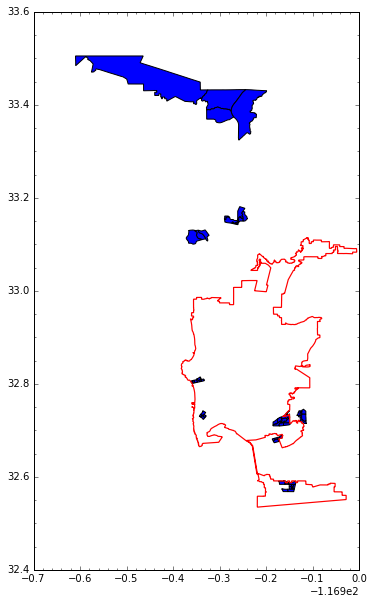

In [1596]:
fig,ax = plt.subplots(1,1, figsize=(10,10))
patches1 = []
for i in range(32,33): 
    print i
    temp = pd.DataFrame(mc_shapes[i].points)
    lon, lat = p1(np.array(temp.loc[0:33632, 0]), np.array(temp.loc[0:33632, 1]), inverse=True)
    poly = plt.Polygon(np.transpose([lon,lat]), fc='none', ec='r', alpha=1.0, lw=1.2, zorder=3)
    patches1.append(poly)
    plt.gca().add_patch(poly)

# Block Groups
patches = []
print len(sdcounty_index)
for i in range(0,len(sdcounty_index)): 
    if sdcounty.loc[sdcounty_index[i], 'tract'] in list(sdcity_census_tracts):
        #if (sdcounty.loc[sdcounty_index[i], 'tract'] not in to_ignore): 
    #temp_tract = sdcounty.loc[sdcounty_index[i], 'tract']
    #temp_bg = sdcounty.loc[sdcounty_index[i], 'blockgroup']
    #if (len(np.where((yak['tract']==temp_tract) & (yak['blockgroup']==temp_bg))[0])==1): 
        barf = pd.DataFrame(shapes[sdcounty_index[i]].points)
        poly = plt.Polygon(barf[[0,1]], fc='blue', ec='k', alpha=1.0)
        patches.append(poly)
        plt.gca().add_patch(poly)

#plt.ylim(32.5,33.5)
#plt.xlim(-117.3,-116.0)

plt.axis('scaled')
plt.minorticks_on()


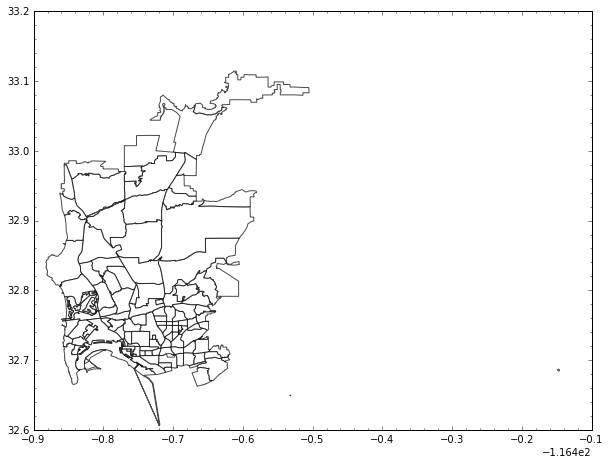

In [1026]:
fig,ax = plt.subplots(1,1, figsize=(10,10))
patches = []
for i in range(0,len(po_shapes)): 
    temp = pd.DataFrame(po_shapes[i].points)
    lon, lat = p1(np.array(temp[0]), np.array(temp[1]), inverse=True)
    if (max(lat)>32.62): 
        poly = plt.Polygon(np.transpose([lon,lat]), fc='white', ec='k', alpha=0.7)
        patches.append(poly)
        plt.gca().add_patch(poly)

        
for j in range(0,len(mc_shapes)): 
    
plt.axis('scaled')
plt.minorticks_on()

#plt.colorbar(p, fraction=0.046, pad=0.04, shrink=1.0, label=column_choice)

#plt.plot(lighting['Geolocation (Longitude)'], lighting['Geolocation (Latitude)'], 'k.')
#plt.plot(graffiti['Geolocation (Longitude)'], graffiti['Geolocation (Latitude)'], 'bs', mfc='none', mec='b')
#plt.plot(dump['Geolocation (Longitude)'], dump['Geolocation (Latitude)'], 'r.')

#plt.ylim(32.5,33.1)
#plt.xlim(-117.3,-116.7)

plt.show()
#mpld3.display()

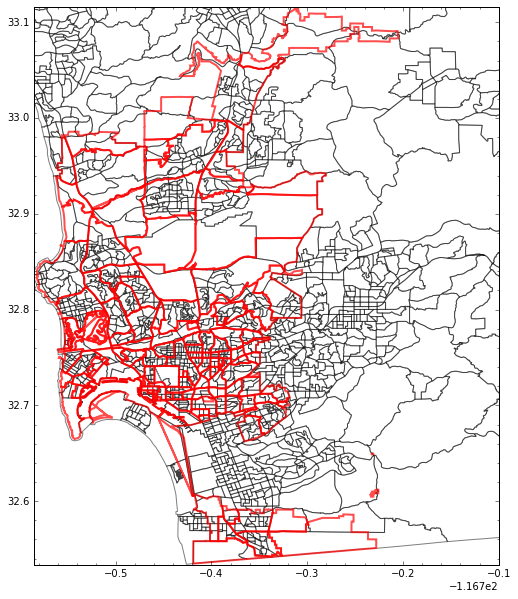

In [870]:
fig,ax = plt.subplots(1,1, figsize=(10,10))

# Block Groups
patches = []
for i in range(0,len(sdcounty_index)): 
    barf = pd.DataFrame(shapes[sdcounty_index[i]].points)
    poly = plt.Polygon(barf[[0,1]], fc='none', ec='k', alpha=0.5)
    patches.append(poly)
    plt.gca().add_patch(poly)

# Police Beats
patches2 = []
for i in range(0,len(police_shapes)): 
    temp = pd.DataFrame(police_shapes[i].points)
    lon, lat = p1(np.array(temp[0]), np.array(temp[1]), inverse=True)
    
    poly = plt.Polygon(np.transpose([lon,lat]), fc='none', ec='r', lw=2., alpha=0.7)
    patches2.append(poly)
    plt.gca().add_patch(poly)


    
    
plt.axis('scaled')
plt.minorticks_on()


plt.ylim(32.533541,33.116178)
plt.xlim(-117.285629,-116.8)

plt.show()

In [432]:
sdcounty['tract'] = sdcounty[2].astype(int)
sdcounty['blockgroup'] = sdcounty[3].astype(float)

In [437]:
sdcounty_only_requests = pd.merge(sdcounty[['tract','blockgroup']], total_reports, 
                                  on=['tract', 'blockgroup'], how='left')

In [440]:
## Want to match report numbers with Census information about the total people in a given area

filenames='aff/block_groups/*with_ann.csv'
test=glob.glob(filenames)

all_of_interest = [30, 2]

for i in all_of_interest: 
    temp = pd.read_csv(test[i], header=1, low_memory=False)
    print i, i, i 
    if (i==30): 
        census = temp.copy()
    if (i!=30): 
        combo = pd.merge(census, temp, on='Id', how='left', suffixes=('', '_' + str(i)))
        census = combo.copy()
        census.reset_index(drop=True)

30 30 30
2 2 2


In [441]:
census_trimmed = census[['GEOGRAPHIC AREA CODES - Census Tract',
                         'GEOGRAPHIC AREA CODES - Block Group',
                         'Estimate; Total']]

census_trimmed.rename(columns={'GEOGRAPHIC AREA CODES - Census Tract': 'tract', 
                               'GEOGRAPHIC AREA CODES - Block Group': 'blockgroup'}, 
                      inplace=True)

In [442]:
len(census_trimmed.sort_values(by='tract'))

1795

In [443]:
# Merge report numbers with population estimates
total_reports_demo = pd.merge(sdcounty_only_requests, census_trimmed, on=['tract', 'blockgroup'], how='left')

In [446]:
# Reports per capita
total_reports_demo['rep_per_cap'] = (total_reports_demo['count'] 
                                     / total_reports_demo['Estimate; Total'])

# Percentage of reports in each category
total_reports_demo['graffiti_per'] = (total_reports_demo['graffiti_count'] 
                                      / total_reports_demo['count'])
total_reports_demo['dump_per'] = (total_reports_demo['dump_count'] 
                                  / total_reports_demo['count'])
total_reports_demo['lighting_per'] = (total_reports_demo['lighting_count'] 
                                      / total_reports_demo['count'])

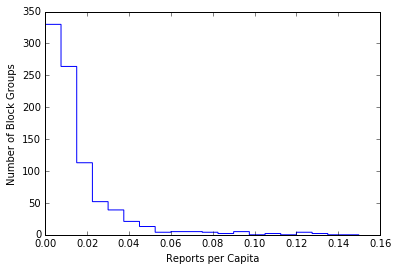

In [447]:
plt.hist(total_reports_demo['rep_per_cap'], bins=20, range=[0,0.15], histtype='step')
plt.xlabel('Reports per Capita')
plt.ylabel('Number of Block Groups')

Plot block groups by reporting, reporting type

In [90]:
census_combo = pd.merge(sdcounty, total_reports_demo, on=['tract', 'blockgroup'], how='left')

/Users/kschles/anaconda/lib/python2.7/site-packages/pandas/indexes/base.py:917: DeprecationWarning: unorderable dtypes; returning scalar but in the future this will be an error
  return self._engine.is_monotonic_increasing
/Users/kschles/anaconda/lib/python2.7/site-packages/pandas/indexes/base.py:917: DeprecationWarning: unorderable dtypes; returning scalar but in the future this will be an error
  return self._engine.is_monotonic_increasing


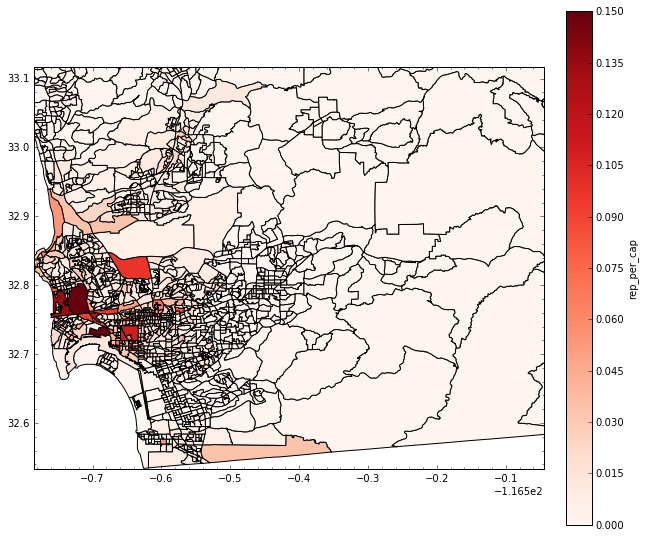

In [864]:
column_choice = 'rep_per_cap'
#column_choice = 'Estimate; Total'

fig,ax = plt.subplots(1,1, figsize=(10,10))
patches = []
for i in range(0,len(sdcounty_index)): 
    barf = pd.DataFrame(shapes[sdcounty_index[i]].points)
    poly = plt.Polygon(barf[[0,1]], fc='none', ec='k', alpha=0.7)
    patches.append(poly)
    #plt.gca().add_patch(poly)

colors = total_reports_demo[column_choice]
p = PatchCollection(patches, cmap='Reds', alpha=1.0)
#colors[np.where(np.isfinite(colors)==False)[0]]=0.0
p.set_array(np.array(colors))
p.set_clim([min(colors),0.15])
#p.set_clim([min(colors),max(colors)])
ax.add_collection(p)

plt.axis('scaled')
plt.minorticks_on()

plt.colorbar(p, fraction=0.046, pad=0.04, shrink=1.0, label=column_choice)

#plt.plot(lighting['Geolocation (Longitude)'], lighting['Geolocation (Latitude)'], 'k.')
#plt.plot(graffiti['Geolocation (Longitude)'], graffiti['Geolocation (Latitude)'], 'bs', mfc='none', mec='b')
#plt.plot(dump['Geolocation (Longitude)'], dump['Geolocation (Latitude)'], 'r.')

plt.ylim(32.533541,33.116178)
plt.xlim(-117.285629,-116.545119)

plt.show()
#mpld3.display()

In [478]:
# If there are no reports, set counts to 0. 
for i in total_reports_demo.columns.values: 
    total_reports_demo.loc[np.where(np.isnan(total_reports_demo[i])==True)[0], i] = 0.0

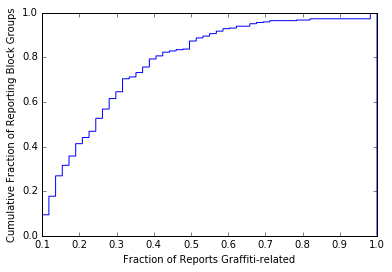

In [486]:
plt.hist(total_reports_demo['graffiti_per'], bins=50, range=[0.1,1.], histtype='step', cumulative=True, normed=True)
plt.xlabel('Fraction of Reports Graffiti-related')
plt.ylabel('Cumulative Fraction of Reporting Block Groups')

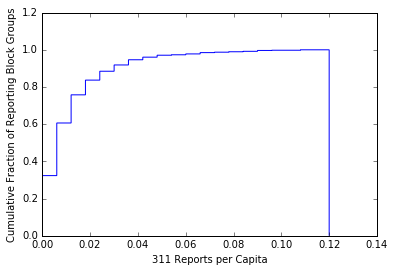

In [492]:
plt.hist(total_reports_demo.loc[np.where(total_reports_demo['rep_per_cap']!=0)[0], 
                                'rep_per_cap'], bins=20, histtype='step', 
         cumulative=True, normed=True, range=[0.0001,0.12])
plt.xlabel('311 Reports per Capita')
plt.ylabel('Cumulative Fraction of Reporting Block Groups')

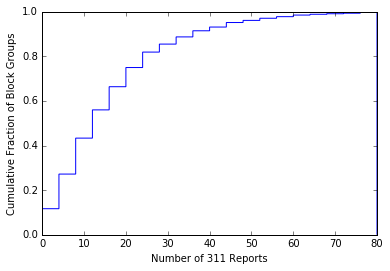

In [495]:
plt.hist(total_reports_demo.loc[np.where(total_reports_demo['count']!=0)[0], 
                                'count'], bins=20, histtype='step', range=[0,80], 
                                cumulative=True, normed=True)
plt.xlabel('Number of 311 Reports')
plt.ylabel('Cumulative Fraction of Block Groups')

In [498]:
# 95% of block groups have a report per capita 
np.percentile(total_reports_demo.loc[np.where(total_reports_demo['rep_per_cap']!=0)[0], 
                                     'rep_per_cap'],5)

0.001060742871662704

Combine with the rest of the census data

In [499]:
census_numeric = pd.read_csv('output_files/census_numeric_0912.csv')

In [ ]:
census_numeric.rename(columns={'block_group': 'blockgroup'}, 
                      inplace=True)
census_numeric.drop('lighting_count', 1, inplace=True)
census_numeric.drop('dump_count', 1, inplace=True)
census_numeric.drop('count', 1, inplace=True)
census_numeric.drop('Estimate; Total', 1, inplace=True)

In [517]:
census_numeric.drop('Estimate; Not Hispanic or Latino: - Two or more races: - Two races including Some other race',1, inplace=True)
census_numeric.drop('Estimate; Not Hispanic or Latino: - Two or more races: - Two races excluding Some other race, and three or more races', 1, inplace=True)

In [562]:
# Age ranges (Male): 
census_numeric['male_5_17'] = census_numeric[['Estimate; Male: - Under 5 years',
                                              'Estimate; Male: - 5 to 9 years',
                                              'Estimate; Male: - 10 to 14 years',
                                              'Estimate; Male: - 15 to 17 years']].sum(axis=1)
census_numeric['male_18_29'] = census_numeric[['Estimate; Male: - 18 and 19 years', 
                                               'Estimate; Male: - 20 years',
                                               'Estimate; Male: - 21 years', 
                                               'Estimate; Male: - 22 to 24 years',
                                               'Estimate; Male: - 25 to 29 years']].sum(axis=1)
census_numeric['male_30_60'] = census_numeric[['Estimate; Male: - 30 to 34 years',
                                               'Estimate; Male: - 35 to 39 years',
                                               'Estimate; Male: - 40 to 44 years',
                                               'Estimate; Male: - 45 to 49 years',
                                               'Estimate; Male: - 50 to 54 years',
                                               'Estimate; Male: - 55 to 59 years']].sum(axis=1)
census_numeric['male_61plus'] = census_numeric[['Estimate; Male: - 60 and 61 years',
                                                'Estimate; Male: - 62 to 64 years',
                                                'Estimate; Male: - 65 and 66 years',
                                                'Estimate; Male: - 67 to 69 years',
                                                'Estimate; Male: - 70 to 74 years',
                                                'Estimate; Male: - 75 to 79 years',
                                                'Estimate; Male: - 80 to 84 years',
                                                'Estimate; Male: - 85 years and over']].sum(axis=1)

In [563]:
# Age ranges (Female): 
census_numeric['female_5_17'] = census_numeric[['Estimate; Female: - Under 5 years',
                                              'Estimate; Female: - 5 to 9 years',
                                              'Estimate; Female: - 10 to 14 years',
                                              'Estimate; Female: - 15 to 17 years']].sum(axis=1)
census_numeric['female_18_29'] = census_numeric[['Estimate; Female: - 18 and 19 years', 
                                               'Estimate; Female: - 20 years',
                                               'Estimate; Female: - 21 years', 
                                               'Estimate; Female: - 22 to 24 years',
                                               'Estimate; Female: - 25 to 29 years']].sum(axis=1)
census_numeric['female_30_60'] = census_numeric[['Estimate; Female: - 30 to 34 years',
                                               'Estimate; Female: - 35 to 39 years',
                                               'Estimate; Female: - 40 to 44 years',
                                               'Estimate; Female: - 45 to 49 years',
                                               'Estimate; Female: - 50 to 54 years',
                                               'Estimate; Female: - 55 to 59 years']].sum(axis=1)
census_numeric['female_61plus'] = census_numeric[['Estimate; Female: - 60 and 61 years',
                                                'Estimate; Female: - 62 to 64 years',
                                                'Estimate; Female: - 65 and 66 years',
                                                'Estimate; Female: - 67 to 69 years',
                                                'Estimate; Female: - 70 to 74 years',
                                                'Estimate; Female: - 75 to 79 years',
                                                'Estimate; Female: - 80 to 84 years',
                                                'Estimate; Female: - 85 years and over']].sum(axis=1)

In [564]:
# Rent ranges 
census_numeric['rent_0_500'] = census_numeric[['Estimate; With cash rent: - Less than $100',
                                               'Estimate; With cash rent: - $100 to $149',
                                               'Estimate; With cash rent: - $150 to $199',
                                               'Estimate; With cash rent: - $200 to $249',
                                               'Estimate; With cash rent: - $250 to $299',
                                               'Estimate; With cash rent: - $300 to $349',
                                               'Estimate; With cash rent: - $350 to $399',
                                               'Estimate; With cash rent: - $400 to $449',
                                               'Estimate; With cash rent: - $450 to $499']].sum(axis=1)
census_numeric['rent_501_1000'] = census_numeric[['Estimate; With cash rent: - $500 to $549',
       'Estimate; With cash rent: - $550 to $599',
       'Estimate; With cash rent: - $600 to $649',
       'Estimate; With cash rent: - $650 to $699',
       'Estimate; With cash rent: - $700 to $749',
       'Estimate; With cash rent: - $750 to $799',
       'Estimate; With cash rent: - $800 to $899',
       'Estimate; With cash rent: - $900 to $999']].sum(axis=1)
census_numeric['rent_1000plus'] = census_numeric[['Estimate; With cash rent: - $1,000 to $1,249',
       'Estimate; With cash rent: - $1,250 to $1,499',
       'Estimate; With cash rent: - $1,500 to $1,999',
       'Estimate; With cash rent: - $2,000 or more']].sum(axis=1)

In [565]:
census_numeric['income_0_25'] = census_numeric[['Estimate; Total: - Less than $10,000',
       'Estimate; Total: - $10,000 to $14,999',
       'Estimate; Total: - $15,000 to $19,999',
       'Estimate; Total: - $20,000 to $24,999']].sum(axis=1)
census_numeric['income_25_50'] = census_numeric[['Estimate; Total: - $25,000 to $29,999',
       'Estimate; Total: - $30,000 to $34,999',
       'Estimate; Total: - $35,000 to $39,999',
       'Estimate; Total: - $40,000 to $44,999',
       'Estimate; Total: - $45,000 to $49,999']].sum(axis=1)
census_numeric['income_50_100'] = census_numeric[['Estimate; Total: - $50,000 to $59,999',
       'Estimate; Total: - $60,000 to $74,999',
       'Estimate; Total: - $75,000 to $99,999']].sum(axis=1)
census_numeric['income_100_150'] = census_numeric[['Estimate; Total: - $100,000 to $124,999',
       'Estimate; Total: - $125,000 to $149,999']].sum(axis=1)
census_numeric['income_150plus'] = census_numeric[['Estimate; Total: - $150,000 to $199,999',
       'Estimate; Total: - $200,000 or more']].sum(axis=1)

In [566]:
census_trimmed = census_numeric[['tract', 'blockgroup', 'male_5_17', 'male_18_29', 'male_30_60', 'male_61plus',
       'female_5_17', 'female_18_29', 'female_30_60', 'female_61plus',
       'rent_0_500', 'rent_501_1000', 'rent_1000plus', 'income_0_25',
       'income_25_50', 'income_50_100', 'income_100_150', 'income_150plus']]

In [202]:
for i in census_numeric.columns.values: 
    census_numeric.loc[np.where(np.isnan(census_numeric[i])==True)[0], i] = 0.0

In [573]:
total_reports_demo.loc[np.where(total_reports_demo['tract']==8504)[0],['tract', 'blockgroup']]

,tract,blockgroup
5,8504.0,1.0
655,8504.0,5.0
682,8504.0,2.0
683,8504.0,4.0
1205,8504.0,3.0


In [575]:
len(total_reports_demo)

1794

In [572]:
census_numeric.loc[[295,296,297],['tract', 'blockgroup']]

,tract,blockgroup
295,8504.0,3.0
296,8504.0,4.0
297,8504.0,5.0


In [533]:
census_big = pd.merge(total_reports_demo, census_trimmed, on=['tract', 'blockgroup'], 
                     how='left')

In [553]:
np.where(census_numeric['tract']==8504)

(array([295, 296, 297]),)

In [567]:
census_numeric.loc[[295,296,297], ['Estimate; Male: - Under 5 years','Estimate; Male: - 5 to 9 years',
                                              'Estimate; Male: - 10 to 14 years',
                                              'Estimate; Male: - 15 to 17 years']].sum(axis=1)

295    0.091346
296    0.199422
297    0.100000
dtype: float64

In [574]:
census_numeric.loc[[295,296,297],['male_5_17', 'blockgroup']]

,male_5_17,blockgroup
295,0.091346,3.0
296,0.199422,4.0
297,0.100000,5.0


In [550]:
census_big[['tract', 'blockgroup', 'male_5_17']]

,tract,blockgroup,male_5_17
0,10013.0,2.0,0.412068
1,10103.0,3.0,0.195455
2,10104.0,2.0,0.324433
3,10103.0,2.0,0.370141
4,10106.0,1.0,0.248452
5,8504.0,1.0,NaN
6,4100.0,4.0,0.236275
7,4200.0,4.0,0.058275
8,5400.0,3.0,0.000000
9,6100.0,2.0,0.066421


male_5_17
r-squared: nan
slope: nan intercept: nan


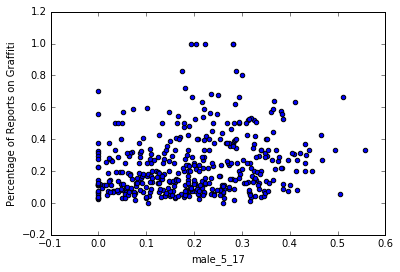

In [547]:
i = 11
cv = list(census_big.columns.values)
print cv[i]
#plt.hist2d(two_groups[cv[i]], two_groups['graffiti_per'], bins=5, cmap='Reds_r')
plt.scatter(census_big[cv[i]], census_big['graffiti_per'])
#plt.scatter(two_groups[cv[i]], two_groups['graffiti_per'], c=two_groups['grich'])
slope, intercept, r_value, p_value, std_err = stats.linregress(census_big[cv[i]], 
                                                              census_big['graffiti_per'])
print "r-squared:", r_value**2
print "slope:", slope, "intercept:", intercept

xer = np.arange(min(census_big[cv[i]]), max(census_big[cv[i]]))
plt.plot(xer, slope*xer + intercept, 'c-')

plt.ylabel('Percentage of Reports on Graffiti')
plt.xlabel(cv[i])

In [215]:
# Extract graffiti-rich areas. 
graffiti_rich = census_big.loc[np.where((census_big['count']>=5) 
                                        & (census_big['graffiti_per']>=0.5))[0]]
graffiti_rich['grich']=1.0

In [214]:
# graffiti-poor areas
graffiti_poor = census_big.loc[np.where((census_big['count']>=5) 
                                        & (census_big['graffiti_per']<0.1))[0]]
graffiti_poor['grich']=0.0

In [216]:
len(graffiti_rich), len(graffiti_poor)

(43, 410)

In [217]:
two_groups = graffiti_rich.append(graffiti_poor,ignore_index = True)

In [186]:
from sklearn.cluster import KMeans

In [218]:
two_groups

,tract,blockgroup,count,graffiti_count,dump_count,lighting_count,Estimate; Total,rep_per_cap,graffiti_per,dump_per,...,Estimate; With cash rent: - $700 to $749,Estimate; With cash rent: - $750 to $799,Estimate; With cash rent: - $800 to $899,Estimate; With cash rent: - $900 to $999,"Estimate; With cash rent: - $1,000 to $1,249","Estimate; With cash rent: - $1,250 to $1,499","Estimate; With cash rent: - $1,500 to $1,999","Estimate; With cash rent: - $2,000 or more",Estimate; No cash rent,grich
0,800.0,1.0,10.0,5.0,0.0,0.0,670.0,0.014925,0.500000,0.000000,...,0.042945,0.288344,0.000000,0.119632,0.177914,0.049080,0.049080,0.000000,51.0,1.0
1,900.0,4.0,14.0,7.0,0.0,0.0,754.0,0.018568,0.500000,0.000000,...,0.000000,0.043643,0.070209,0.024668,0.096774,0.085389,0.018975,0.000000,0.0,1.0
2,900.0,5.0,7.0,4.0,0.0,0.0,716.0,0.009777,0.571429,0.000000,...,0.096886,0.000000,0.141869,0.342561,0.128028,0.100346,0.166090,0.000000,0.0,1.0
3,1600.0,1.0,52.0,33.0,0.0,5.0,2110.0,0.024645,0.634615,0.000000,...,0.000000,0.124731,0.075269,0.045161,0.292473,0.363441,0.012903,0.000000,0.0,1.0
4,2201.0,1.0,57.0,29.0,4.0,3.0,1806.0,0.031561,0.508772,0.070175,...,0.000000,0.041509,0.211321,0.183019,0.260377,0.039623,0.000000,0.000000,0.0,1.0
5,2401.0,1.0,71.0,36.0,7.0,0.0,1486.0,0.047779,0.507042,0.098592,...,0.019802,0.214521,0.039604,0.204620,0.184818,0.165017,0.042904,0.092409,0.0,1.0
6,2601.0,1.0,23.0,19.0,2.0,0.0,2379.0,0.009668,0.826087,0.086957,...,0.000000,0.000000,0.274611,0.020725,0.209845,0.204663,0.178756,0.000000,0.0,1.0
7,2602.0,1.0,25.0,14.0,4.0,0.0,1378.0,0.018142,0.560000,0.160000,...,0.000000,0.104418,0.124498,0.257028,0.345382,0.000000,0.000000,0.000000,36.0,1.0
8,2708.0,4.0,6.0,4.0,0.0,0.0,2321.0,0.002585,0.666667,0.000000,...,0.131481,0.192593,0.170370,0.244444,0.200000,0.000000,0.000000,0.000000,8.0,1.0
9,2903.0,2.0,13.0,7.0,0.0,0.0,1059.0,0.012276,0.538462,0.000000,...,0.000000,0.083333,0.095238,0.142857,0.000000,0.000000,0.678571,0.000000,9.0,1.0


In [235]:
cv = list(two_groups.columns.values)

['tract',
 'blockgroup',
 'count',
 'graffiti_count',
 'dump_count',
 'lighting_count',
 'Estimate; Total',
 'rep_per_cap',
 'graffiti_per',
 'dump_per',
 'lighting_per',
 'Id2',
 'Estimate; Total:',
 'Estimate; Male:',
 'Estimate; Male: - Under 5 years',
 'Estimate; Male: - 5 to 9 years',
 'Estimate; Male: - 10 to 14 years',
 'Estimate; Male: - 15 to 17 years',
 'Estimate; Male: - 18 and 19 years',
 'Estimate; Male: - 20 years',
 'Estimate; Male: - 21 years',
 'Estimate; Male: - 22 to 24 years',
 'Estimate; Male: - 25 to 29 years',
 'Estimate; Male: - 30 to 34 years',
 'Estimate; Male: - 35 to 39 years',
 'Estimate; Male: - 40 to 44 years',
 'Estimate; Male: - 45 to 49 years',
 'Estimate; Male: - 50 to 54 years',
 'Estimate; Male: - 55 to 59 years',
 'Estimate; Male: - 60 and 61 years',
 'Estimate; Male: - 62 to 64 years',
 'Estimate; Male: - 65 and 66 years',
 'Estimate; Male: - 67 to 69 years',
 'Estimate; Male: - 70 to 74 years',
 'Estimate; Male: - 75 to 79 years',
 'Estimate; Mal

In [364]:
from scipy import stats

In [220]:
random_state = 117
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(two_groups)

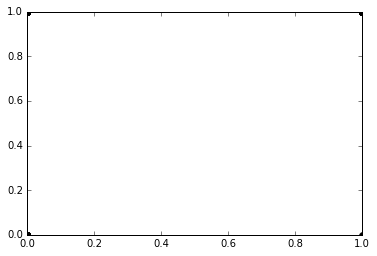

In [223]:
plt.plot(two_groups['grich'], y_pred, 'ko')
plt.show()

In [229]:
barf = pd.DataFrame(graffiti_poor.corr()['graffiti_per'])

In [230]:
barf.sort_values(by='graffiti_per')

,graffiti_per
Estimate; Male: - 70 to 74 years,-0.247320
Estimate; Not Hispanic or Latino:,-0.241455
"Estimate; Total: - $150,000 to $199,999",-0.240835
Estimate; Male: - 65 and 66 years,-0.234262
"Estimate; Total: - $125,000 to $149,999",-0.225135
tract,-0.199175
Estimate; Female:,-0.193681
Estimate; Total:,-0.193312
Estimate; Male:,-0.188357
"Estimate; Not Hispanic or Latino: - Two or more races: - Two races excluding Some other race, and three or more races",-0.180892
